# TRAINING NOTEBOOK
## BARBADOS TRAFFIC ANALYSIS CHALLENGE

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime
from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree

# Exploring Dataset

In [4]:
dataset = pd.read_csv("final_updated_dataset_features.csv")
dataset.dtypes

,0
video_name,object
camera,object
date_time,object
number_of_vehicles_entry,int64
number_of_vehicles_exit,int64
number_of vehicles_roundabout,int64
avg_time_spent_entry,float64
avg_time_spent_exit,float64
avg_time_spent_from_roundabout,float64
avg_idle_time_entry,float64


/tmp/ipython-input-496042415.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='congestion_enter_rating', data=dataset, palette='husl')


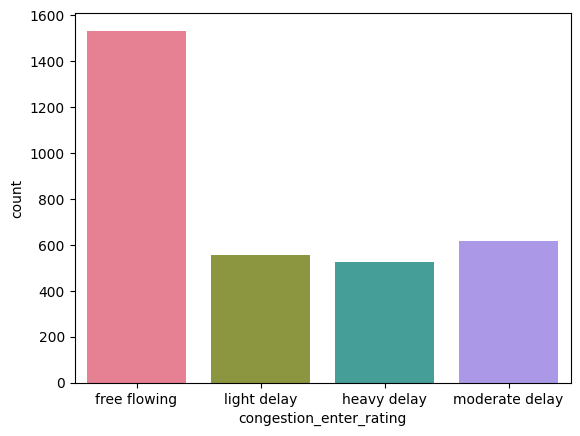

In [5]:
sns.countplot(x='congestion_enter_rating', data=dataset, palette='husl')
plt.show()

/tmp/ipython-input-1499423493.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='congestion_exit_rating', data=dataset, palette='husl')


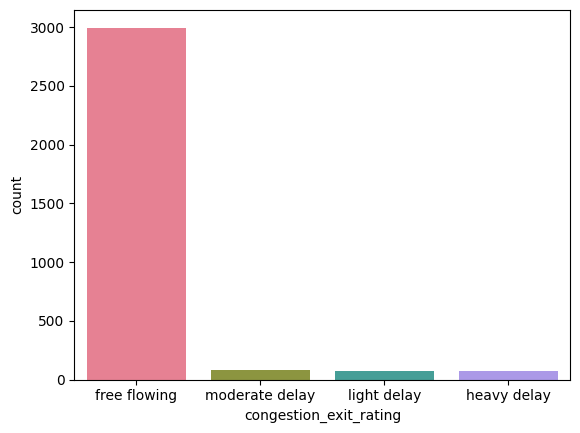

In [6]:
sns.countplot(x='congestion_exit_rating', data=dataset, palette='husl')
plt.show()

- We can clearly see the class imbalance here.

In [7]:
dataset.groupby("congestion_enter_rating").mean(numeric_only=True)

,number_of_vehicles_entry,number_of_vehicles_exit,number_of vehicles_roundabout,avg_time_spent_entry,avg_time_spent_exit,avg_time_spent_from_roundabout,avg_idle_time_entry,avg_idle_time_exit,avg_idle_time_from_roundabout,idle_0_entry,...,time_spent_0_entry,time_spent_1_entry,time_spent_2_entry,time_spent_3_entry,time_spent_4_entry,time_spent_0_exit,time_spent_1_exit,time_spent_2_exit,time_spent_3_exit,time_spent_4_exit
congestion_enter_rating,,,,,,,,,,,,,,,,,,,,,
free flowing,26.425962,12.809524,12.021526,40.294047,11.471069,7.407229,12.315603,3.736538,0.041902,20.696673,...,13.741683,4.191129,3.553164,1.984997,2.954990,7.836269,4.838878,0.062622,0.027397,0.044357
heavy delay,44.452471,17.186312,18.492395,55.804401,8.609916,6.964819,19.209724,2.618423,0.041247,32.834601,...,21.699620,6.874525,5.290875,3.416350,7.171103,10.218631,6.596958,0.190114,0.110266,0.070342
light delay,35.266667,15.753153,16.488288,45.485238,10.710277,7.748172,14.789512,3.496811,0.083323,27.282883,...,19.028829,5.039640,4.257658,2.598198,4.342342,9.111712,6.400000,0.111712,0.050450,0.079279
moderate delay,39.582114,15.278049,18.294309,52.188387,9.410892,7.816617,17.666771,3.023266,0.072781,29.639024,...,21.058537,5.104065,4.552846,3.050407,5.816260,9.043902,6.003252,0.125203,0.043902,0.061789


In [8]:
new_dataset = dataset.copy()
new_dataset['date_time'] = pd.to_datetime(new_dataset['date_time'])
mapping = {
    "free flowing": 0,
    "light delay": 1,
    "moderate delay": 2,
    "heavy delay": 3
}
signal_mapping = {
    'none': 0,
    'low': 1,
    'medium': 2,
    'high': 3
}
new_dataset["congestion_enter_rating"] = new_dataset["congestion_enter_rating"].map(mapping)
new_dataset["congestion_exit_rating"] = new_dataset["congestion_exit_rating"].map(mapping)
new_dataset["signaling"] = new_dataset["signaling"].map(signal_mapping)

In [9]:
num_cols = [col for col in new_dataset.columns if new_dataset[col].dtype != object]
num_cols

['date_time',
 'number_of_vehicles_entry',
 'number_of_vehicles_exit',
 'number_of vehicles_roundabout',
 'avg_time_spent_entry',
 'avg_time_spent_exit',
 'avg_time_spent_from_roundabout',
 'avg_idle_time_entry',
 'avg_idle_time_exit',
 'avg_idle_time_from_roundabout',
 'idle_0_entry',
 'idle_1_entry',
 'idle_2_entry',
 'idle_3_entry',
 'idle_4_entry',
 'idle_0_exit',
 'idle_1_exit',
 'idle_2_exit',
 'idle_3_exit',
 'idle_4_exit',
 'time_spent_0_entry',
 'time_spent_1_entry',
 'time_spent_2_entry',
 'time_spent_3_entry',
 'time_spent_4_entry',
 'time_spent_0_exit',
 'time_spent_1_exit',
 'time_spent_2_exit',
 'time_spent_3_exit',
 'time_spent_4_exit',
 'signaling',
 'congestion_enter_rating',
 'congestion_exit_rating']

In [10]:
new_dataset[num_cols].corr()['congestion_enter_rating'].sort_values(ascending=False)

,congestion_enter_rating
congestion_enter_rating,1.000000
number_of_vehicles_entry,0.547112
idle_0_entry,0.498626
time_spent_4_entry,0.449048
time_spent_0_entry,0.378356
avg_idle_time_entry,0.375422
congestion_exit_rating,0.371852
idle_4_entry,0.353457
avg_time_spent_entry,0.351187
signaling,0.345759


In [11]:
new_dataset[num_cols].corr()['congestion_exit_rating'].sort_values(ascending=False)

,congestion_exit_rating
congestion_exit_rating,1.000000
congestion_enter_rating,0.371852
number_of_vehicles_entry,0.214371
idle_0_entry,0.196517
time_spent_4_entry,0.175774
time_spent_1_entry,0.136501
idle_4_entry,0.127303
idle_2_entry,0.116394
idle_1_entry,0.112408
time_spent_0_entry,0.112238


#

In [12]:
def create_time_features(df):
  df_time = df.copy()
  df_time['hour'] = df_time['date_time'].dt.hour
  df_time['minute'] = df_time['date_time'].dt.minute

  df_time['hour_sin'] = np.sin(2 * np.pi * df_time['hour'] / 24)
  df_time['hour_cos'] = np.cos(2 * np.pi * df_time['hour'] / 24)
  return df_time

def create_previous_features(df, cols, window=5):
  df_prev = df.copy()
  for col in cols:
    for i in range(1, window + 1):
      df_prev[f"{col}_t_m_{i}"] = df_prev.groupby('camera')[col].shift(i)

  return df_prev

def create_target_features(df, cols, window=5):
  df_target = df.copy()
  for col in cols:
    for i in range(1, window + 1):
      df_target[f"{col}_t_{i}"] = df_target.groupby('camera')[col].shift(-i)
  return df_target

In [13]:
df = new_dataset.copy()
lagged_features = ['congestion_enter_rating', 'congestion_exit_rating', 'signaling', 'number_of_vehicles_entry', 'number_of_vehicles_exit', 'number_of vehicles_roundabout', 'idle_0_entry', 'time_spent_0_entry', 'time_spent_4_entry']
df = create_time_features(df)
df = create_previous_features(df, lagged_features)
df = create_target_features(df, ['congestion_enter_rating', 'congestion_exit_rating'])
df.columns

Index(['video_name', 'camera', 'date_time', 'number_of_vehicles_entry',
       'number_of_vehicles_exit', 'number_of vehicles_roundabout',
       'avg_time_spent_entry', 'avg_time_spent_exit',
       'avg_time_spent_from_roundabout', 'avg_idle_time_entry',
       'avg_idle_time_exit', 'avg_idle_time_from_roundabout', 'idle_0_entry',
       'idle_1_entry', 'idle_2_entry', 'idle_3_entry', 'idle_4_entry',
       'idle_0_exit', 'idle_1_exit', 'idle_2_exit', 'idle_3_exit',
       'idle_4_exit', 'time_spent_0_entry', 'time_spent_1_entry',
       'time_spent_2_entry', 'time_spent_3_entry', 'time_spent_4_entry',
       'time_spent_0_exit', 'time_spent_1_exit', 'time_spent_2_exit',
       'time_spent_3_exit', 'time_spent_4_exit', 'signaling',
       'congestion_enter_rating', 'congestion_exit_rating', 'hour', 'minute',
       'hour_sin', 'hour_cos', 'congestion_enter_rating_t_m_1',
       'congestion_enter_rating_t_m_2', 'congestion_enter_rating_t_m_3',
       'congestion_enter_rating_t_m_4', '

In [14]:
len(df)

3229

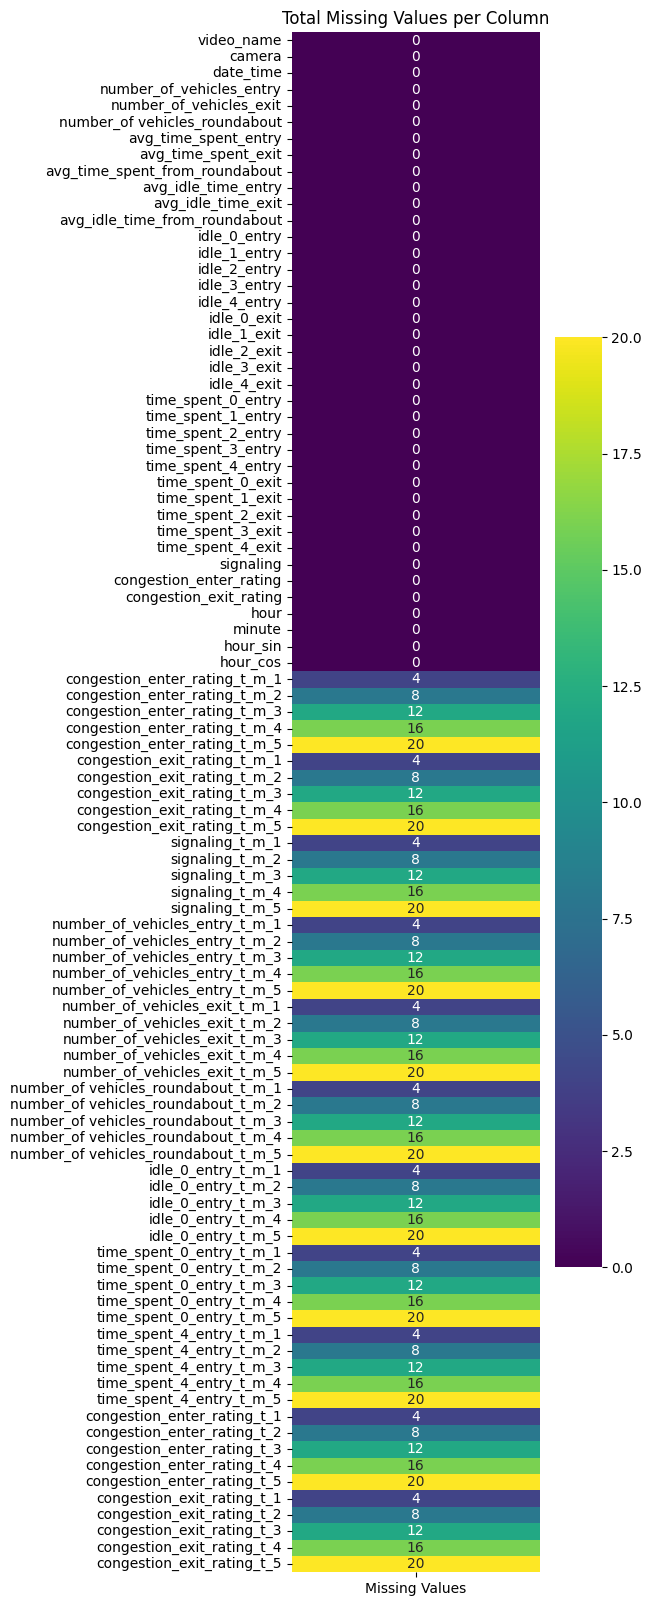

In [15]:
def plot_nan_value_counts(df):
  nan_counts = df.isna().sum().to_frame(name="Missing Values")

  plt.figure(figsize=(4, 20))
  sns.heatmap(nan_counts, annot=True, fmt="d", cmap="viridis", cbar=True)
  plt.title("Total Missing Values per Column")
  plt.show()

plot_nan_value_counts(df)

/tmp/ipython-input-1850039056.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_trimmed = df.groupby('camera', group_keys=False).apply(lambda x:x.iloc[5: -5])


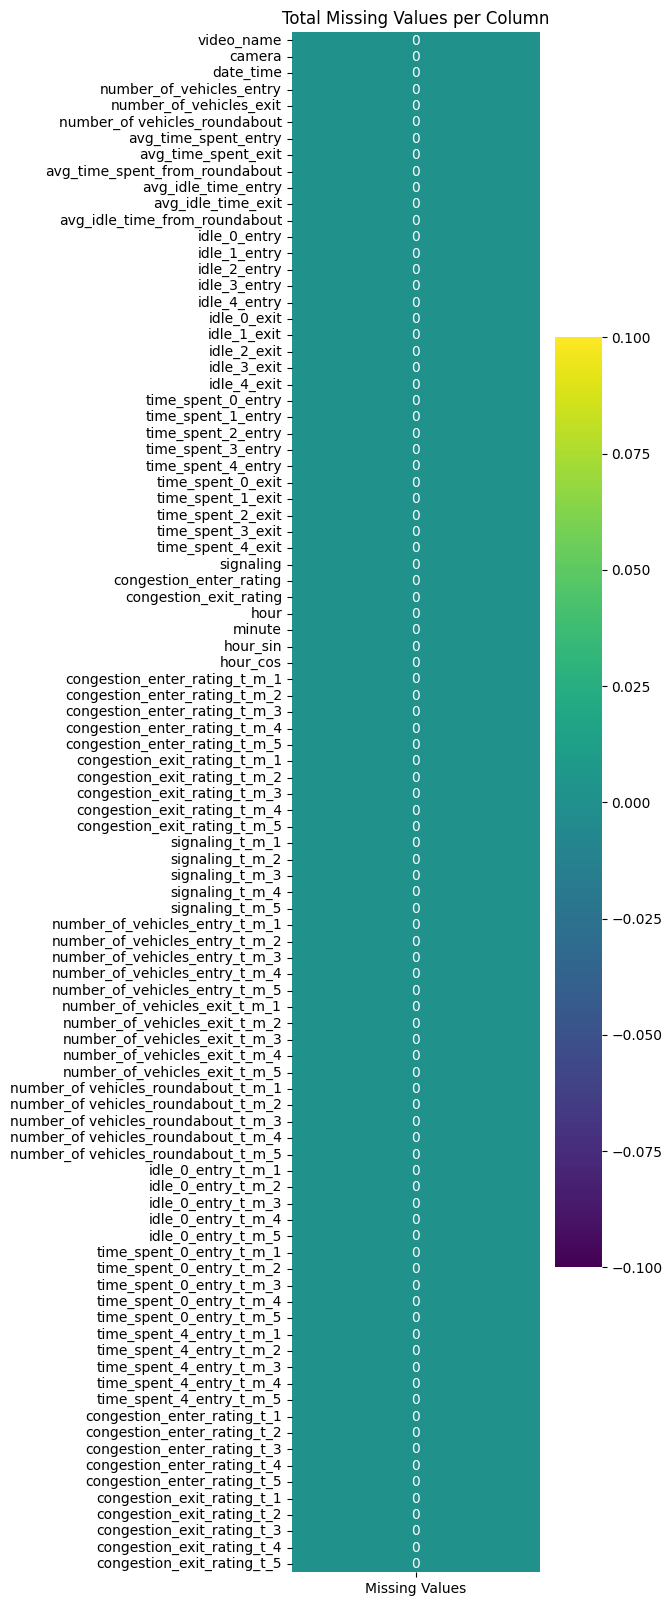

In [16]:
df_trimmed = df.groupby('camera', group_keys=False).apply(lambda x:x.iloc[5: -5])
plot_nan_value_counts(df_trimmed)

In [17]:
drop_cols = ['video_name', 'date_time']
df_final = df_trimmed.drop(drop_cols, axis=1)
df_final.columns

Index(['camera', 'number_of_vehicles_entry', 'number_of_vehicles_exit',
       'number_of vehicles_roundabout', 'avg_time_spent_entry',
       'avg_time_spent_exit', 'avg_time_spent_from_roundabout',
       'avg_idle_time_entry', 'avg_idle_time_exit',
       'avg_idle_time_from_roundabout', 'idle_0_entry', 'idle_1_entry',
       'idle_2_entry', 'idle_3_entry', 'idle_4_entry', 'idle_0_exit',
       'idle_1_exit', 'idle_2_exit', 'idle_3_exit', 'idle_4_exit',
       'time_spent_0_entry', 'time_spent_1_entry', 'time_spent_2_entry',
       'time_spent_3_entry', 'time_spent_4_entry', 'time_spent_0_exit',
       'time_spent_1_exit', 'time_spent_2_exit', 'time_spent_3_exit',
       'time_spent_4_exit', 'signaling', 'congestion_enter_rating',
       'congestion_exit_rating', 'hour', 'minute', 'hour_sin', 'hour_cos',
       'congestion_enter_rating_t_m_1', 'congestion_enter_rating_t_m_2',
       'congestion_enter_rating_t_m_3', 'congestion_enter_rating_t_m_4',
       'congestion_enter_rating_t_m

In [18]:
categorical_features = [col for col in df_final.columns if df_final[col].dtype == object]
df_cat = pd.get_dummies(df_final[categorical_features], drop_first=True, dtype=int)
df_final = pd.concat([df_final.drop(categorical_features, axis=1), df_cat], axis=1)
df_final.columns

Index(['number_of_vehicles_entry', 'number_of_vehicles_exit',
       'number_of vehicles_roundabout', 'avg_time_spent_entry',
       'avg_time_spent_exit', 'avg_time_spent_from_roundabout',
       'avg_idle_time_entry', 'avg_idle_time_exit',
       'avg_idle_time_from_roundabout', 'idle_0_entry', 'idle_1_entry',
       'idle_2_entry', 'idle_3_entry', 'idle_4_entry', 'idle_0_exit',
       'idle_1_exit', 'idle_2_exit', 'idle_3_exit', 'idle_4_exit',
       'time_spent_0_entry', 'time_spent_1_entry', 'time_spent_2_entry',
       'time_spent_3_entry', 'time_spent_4_entry', 'time_spent_0_exit',
       'time_spent_1_exit', 'time_spent_2_exit', 'time_spent_3_exit',
       'time_spent_4_exit', 'signaling', 'congestion_enter_rating',
       'congestion_exit_rating', 'hour', 'minute', 'hour_sin', 'hour_cos',
       'congestion_enter_rating_t_m_1', 'congestion_enter_rating_t_m_2',
       'congestion_enter_rating_t_m_3', 'congestion_enter_rating_t_m_4',
       'congestion_enter_rating_t_m_5', 'cong

# Downsampling

In [19]:
df_final['congestion_enter_rating_t_1'].value_counts()

,count
congestion_enter_rating_t_1,
0.0,1502
2.0,612
1.0,552
3.0,523


In [20]:
drop_index = df_final[
    ((df_final['congestion_enter_rating_t_1'] == 0) &
    (df_final['congestion_enter_rating_t_2'] == 0) &
    (df_final['congestion_enter_rating_t_3'] == 0) &
    (df_final['congestion_enter_rating_t_4'] == 0) &
    (df_final['congestion_enter_rating_t_5'] == 0))
    ].sample(frac=0.6, random_state=42).index

df_final = df_final.drop(drop_index).reset_index(drop=True)
df_final.shape

(2969, 94)

In [21]:
df_final['congestion_enter_rating_t_1'].value_counts()

,count
congestion_enter_rating_t_1,
0.0,1282
2.0,612
1.0,552
3.0,523


In [22]:
target_enter_features = ['congestion_enter_rating_t_1', 'congestion_enter_rating_t_2', 'congestion_enter_rating_t_3', 'congestion_enter_rating_t_4', 'congestion_enter_rating_t_5']
target_exit_features = ['congestion_exit_rating_t_1', 'congestion_exit_rating_t_2', 'congestion_exit_rating_t_3', 'congestion_exit_rating_t_4', 'congestion_exit_rating_t_5']

X = df_final.drop(target_enter_features + target_exit_features, axis=1)
y_enter = df_final[target_enter_features]
y_exit = df_final[target_exit_features]

df_final.shape, X.shape, y_enter.shape, y_exit.shape

((2969, 94), (2969, 84), (2969, 5), (2969, 5))

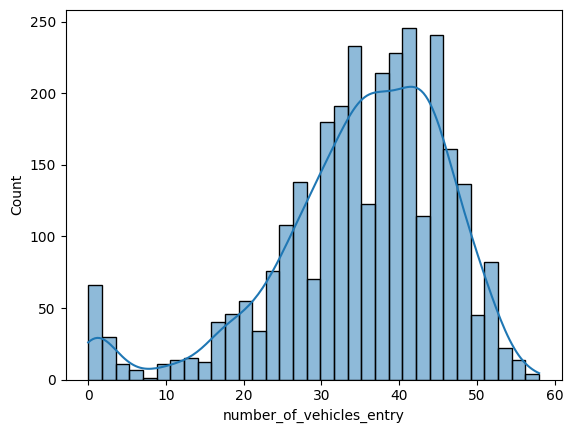

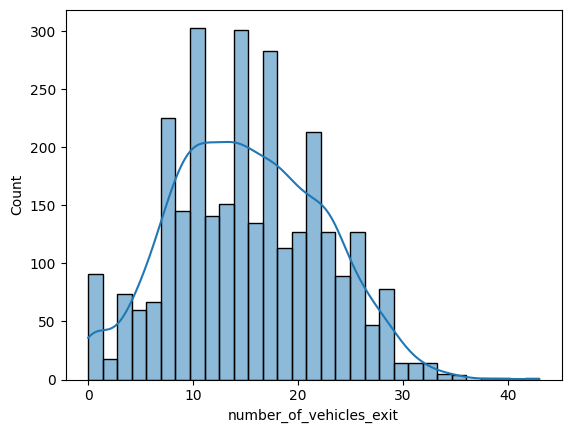

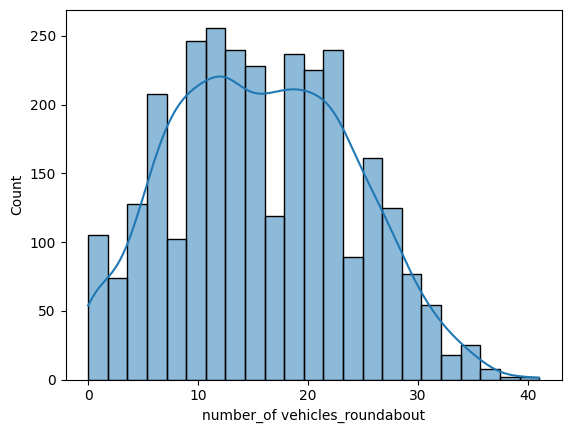

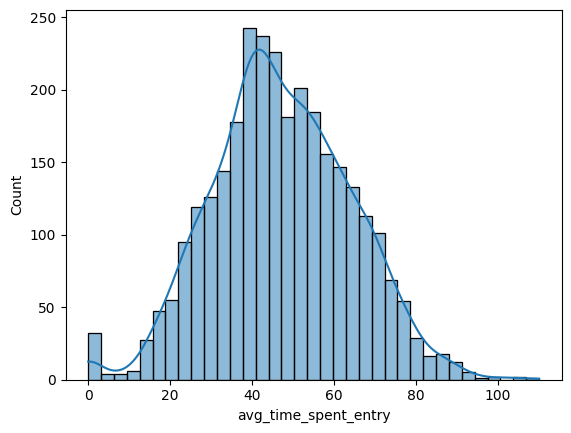

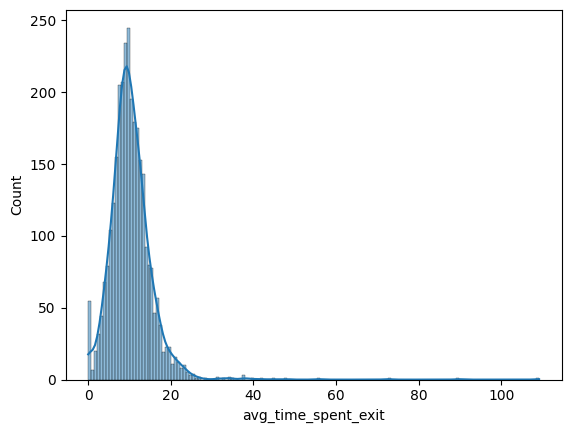

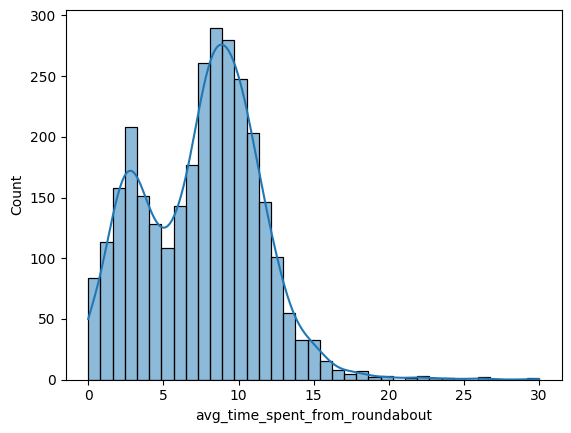

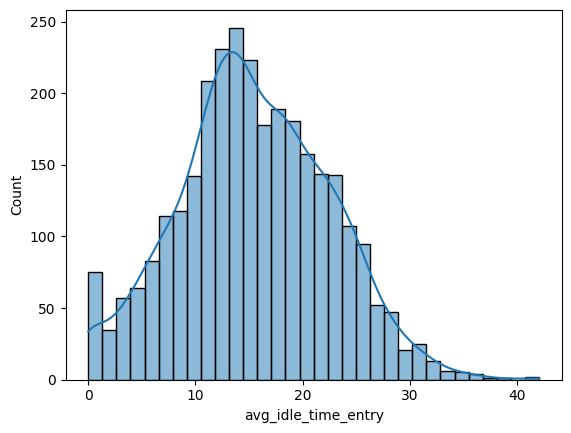

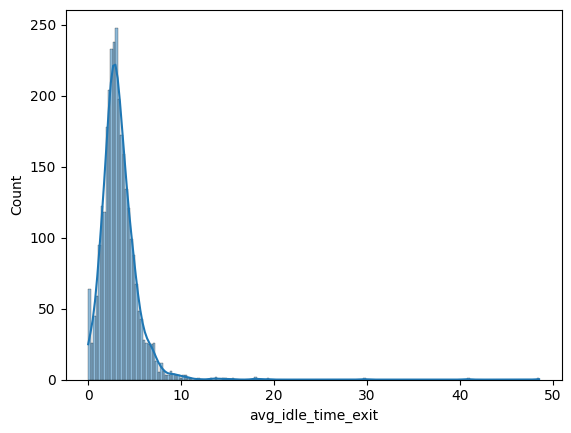

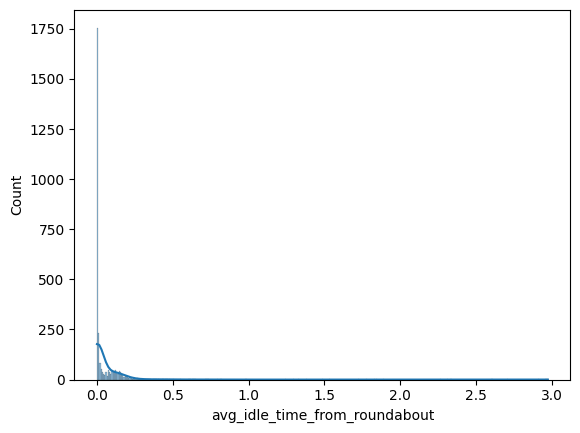

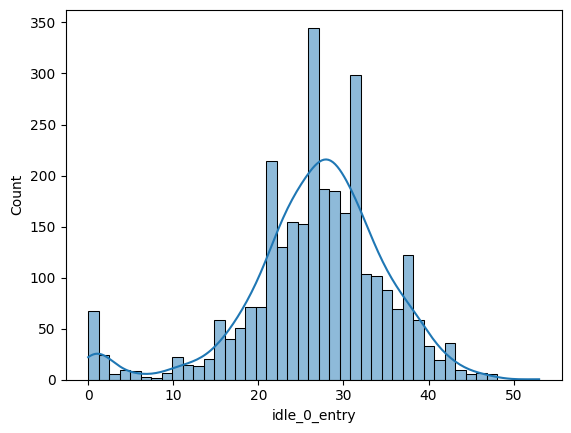

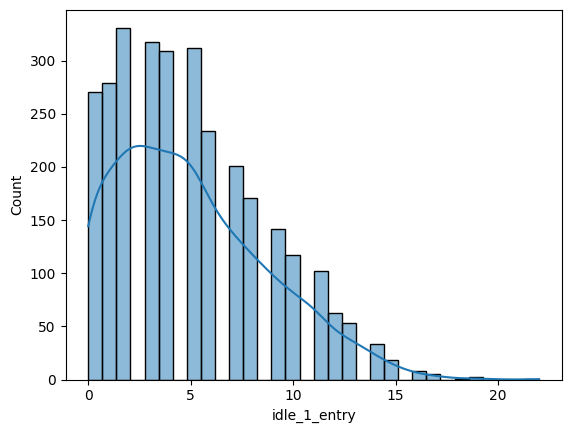

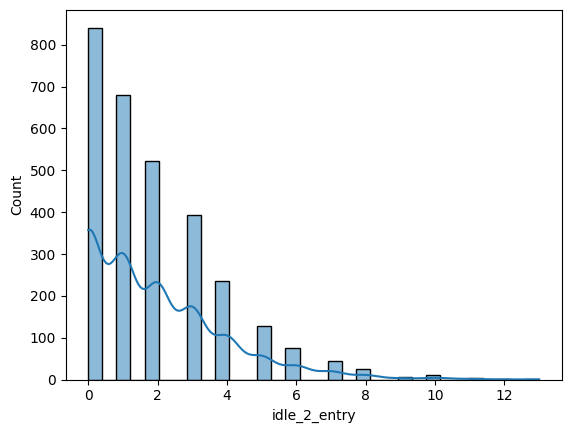

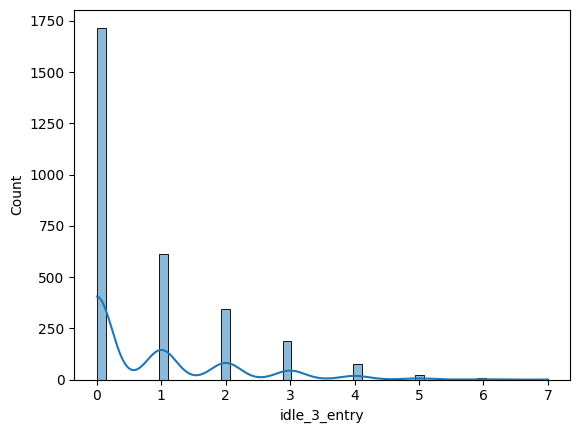

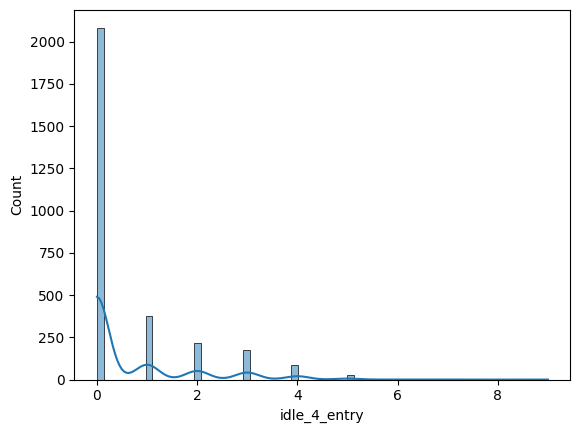

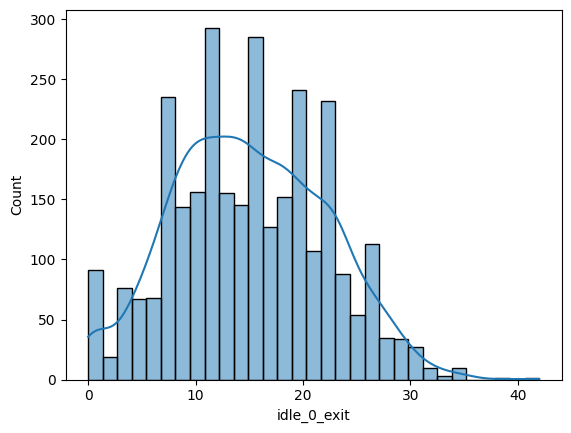

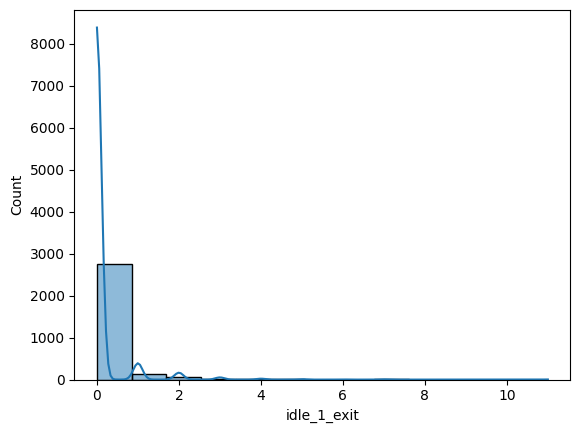

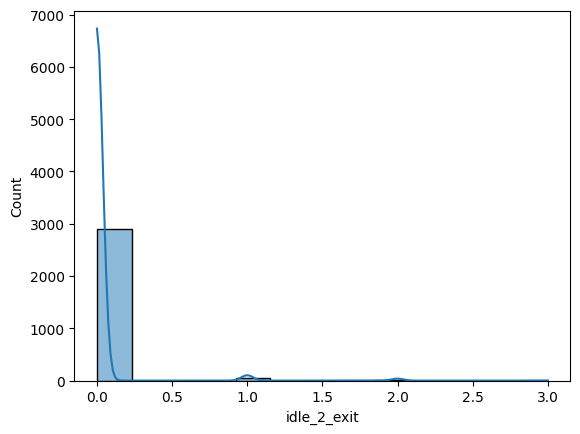

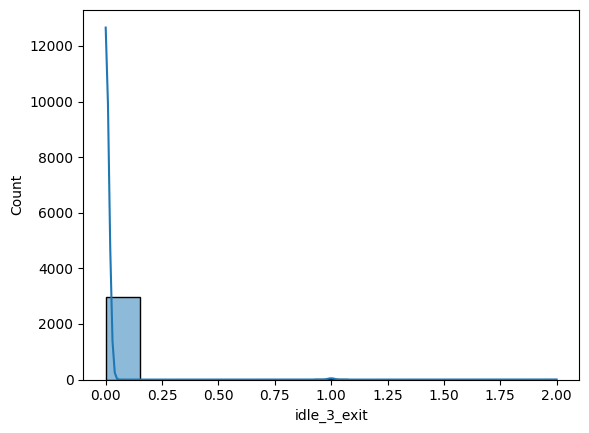

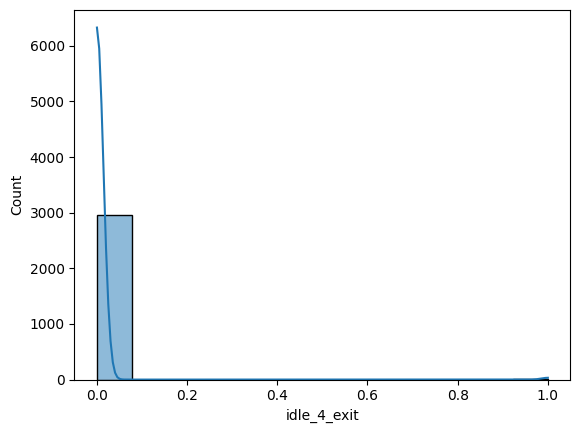

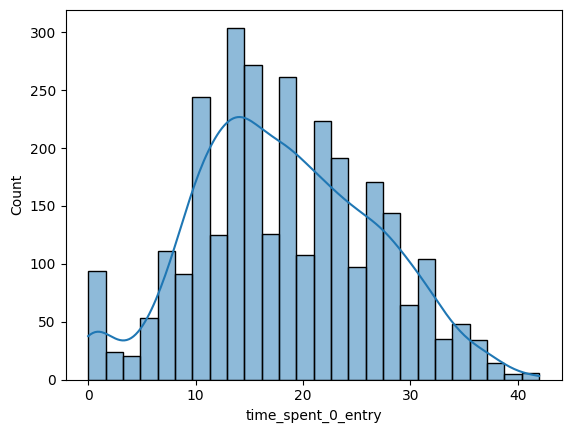

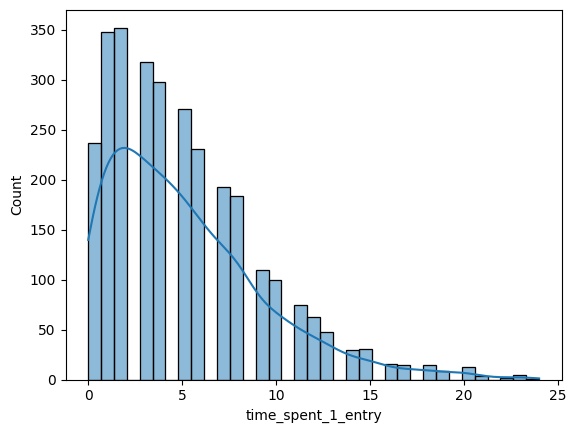

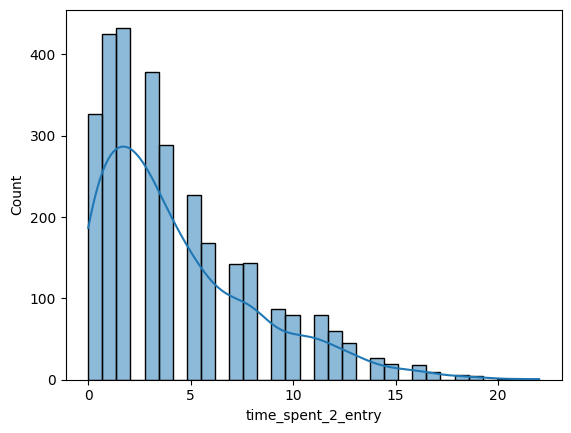

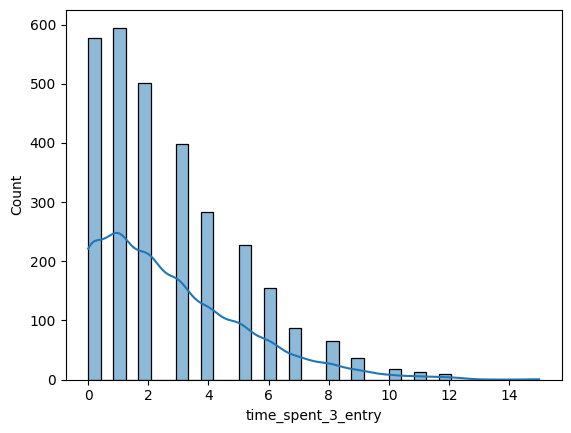

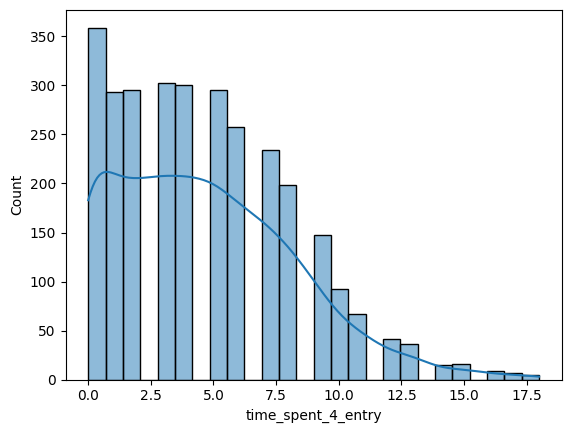

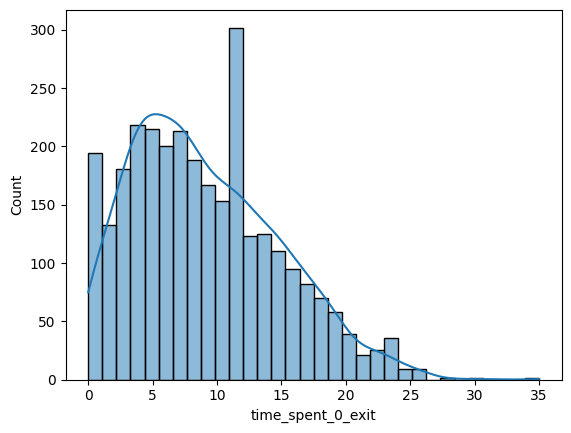

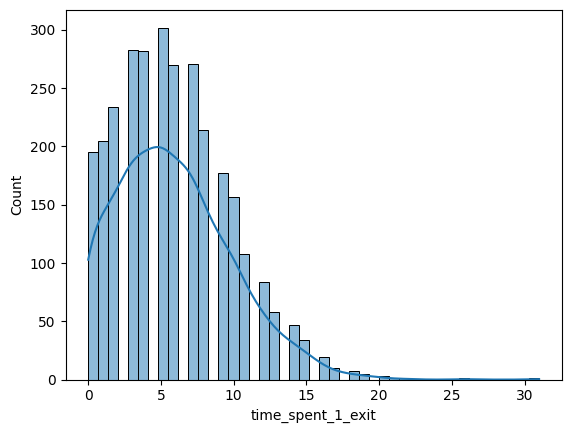

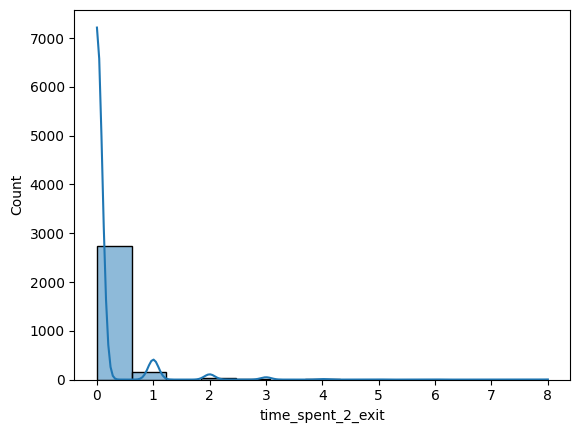

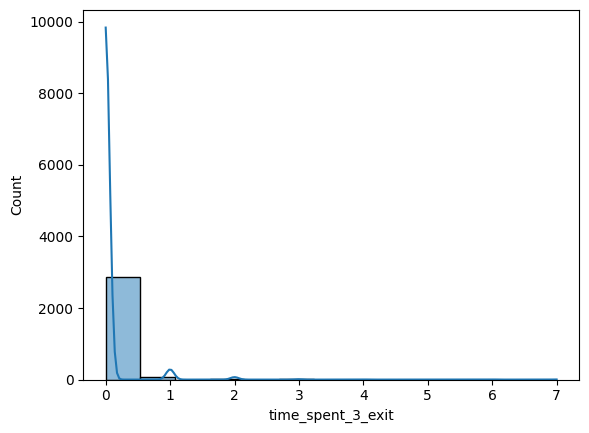

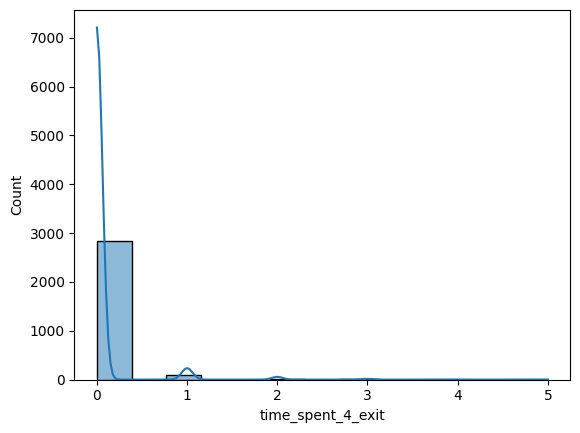

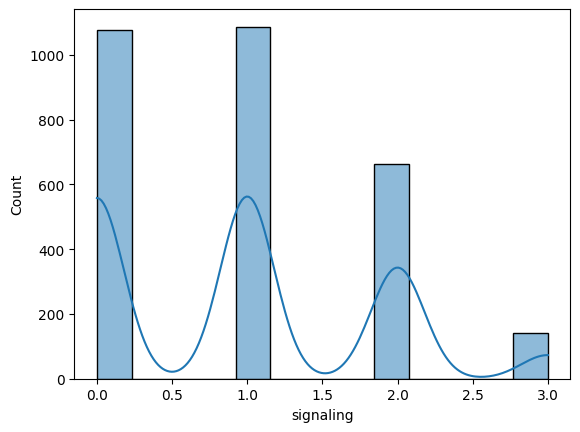

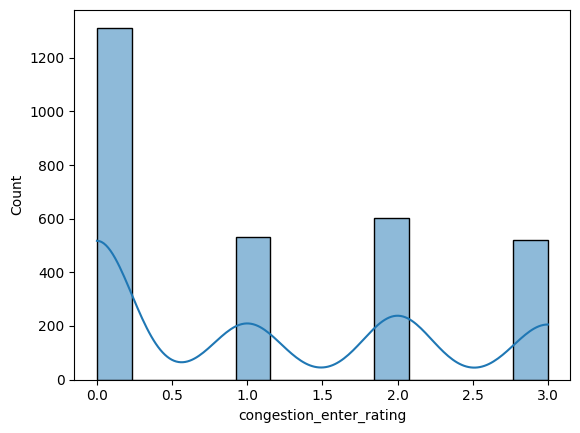

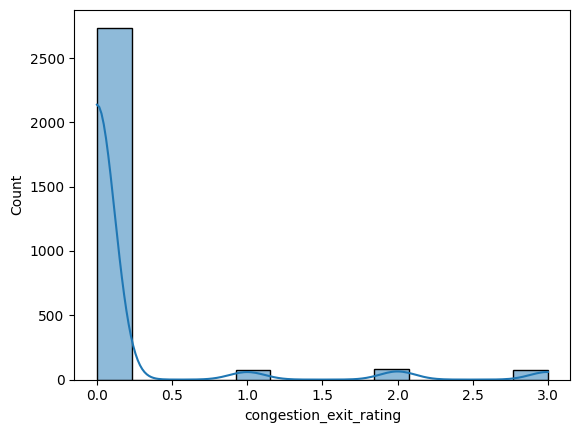

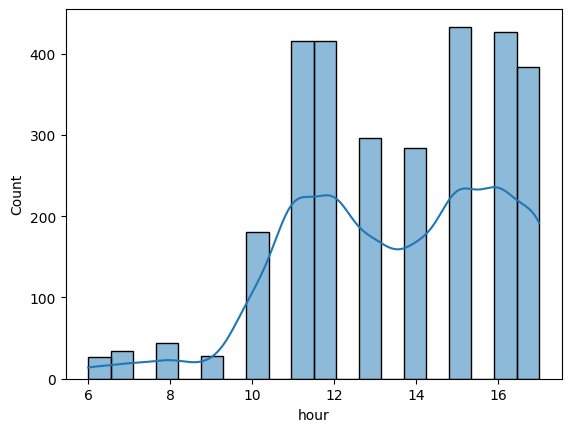

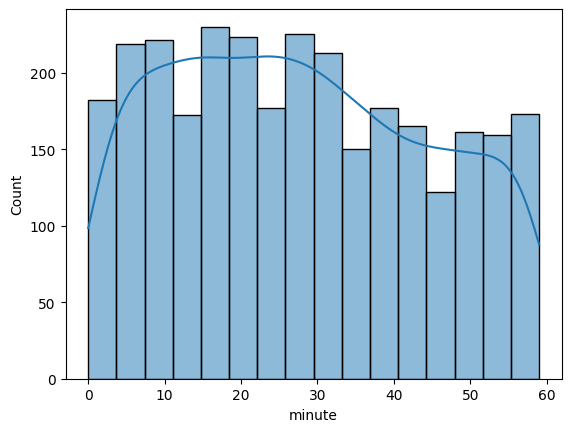

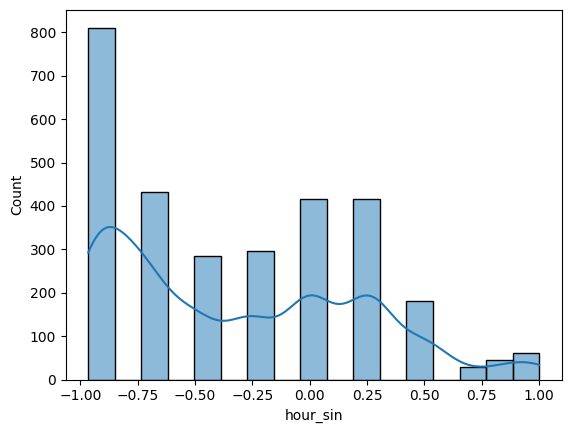

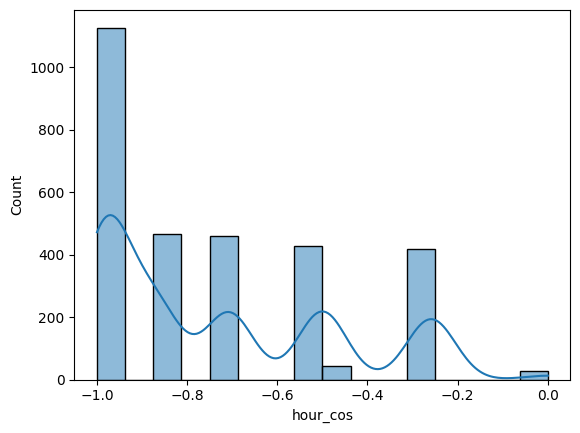

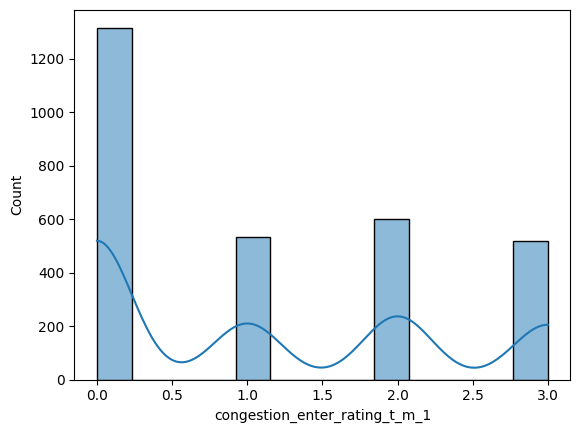

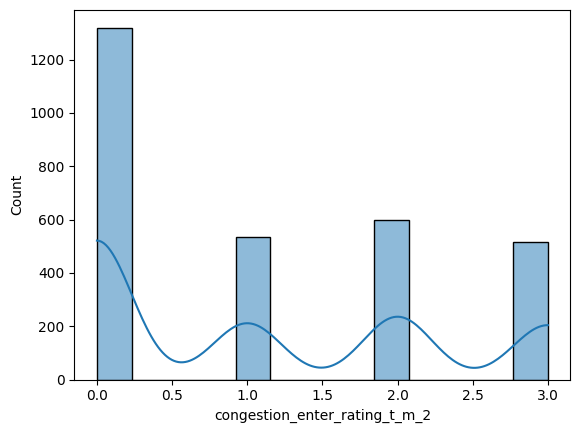

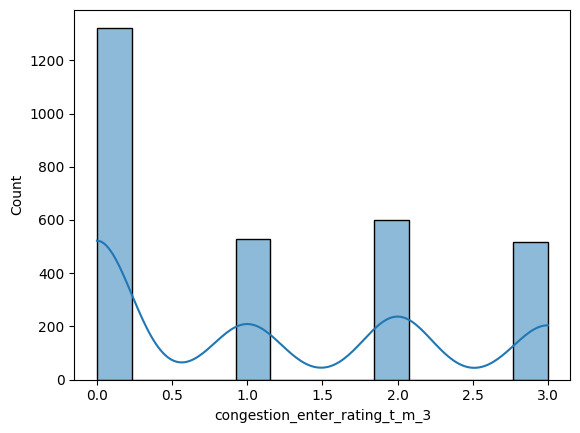

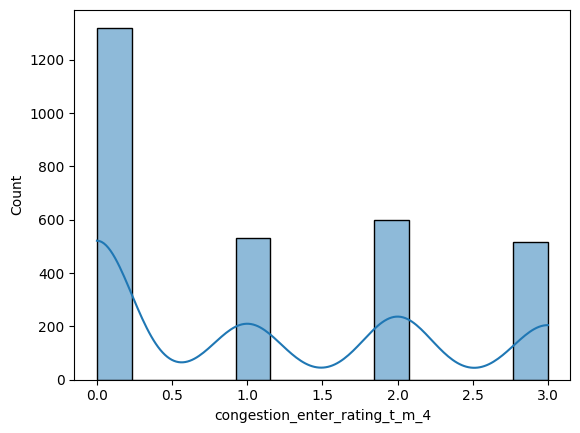

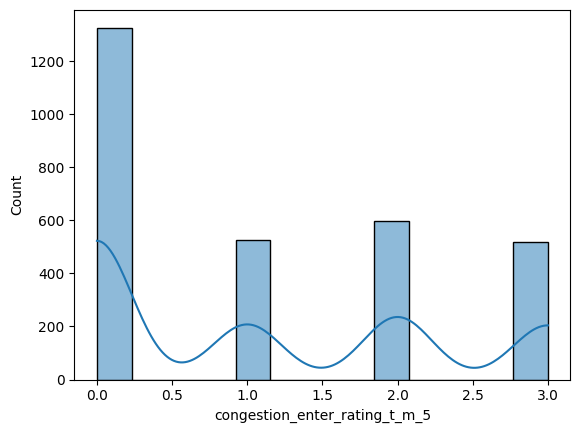

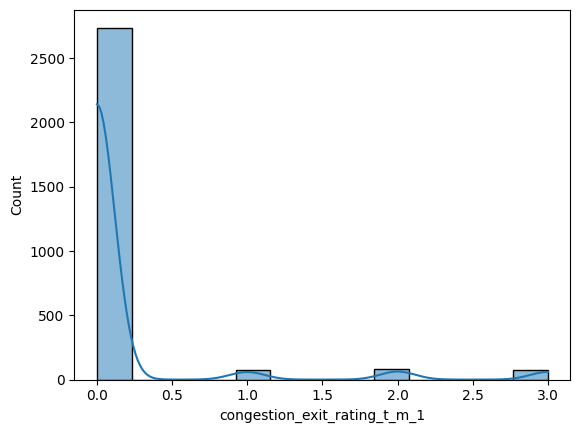

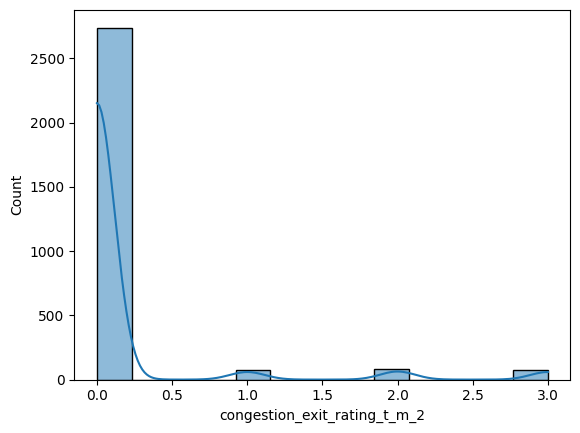

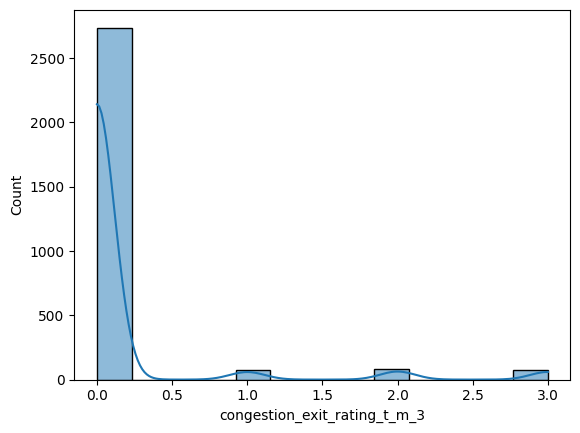

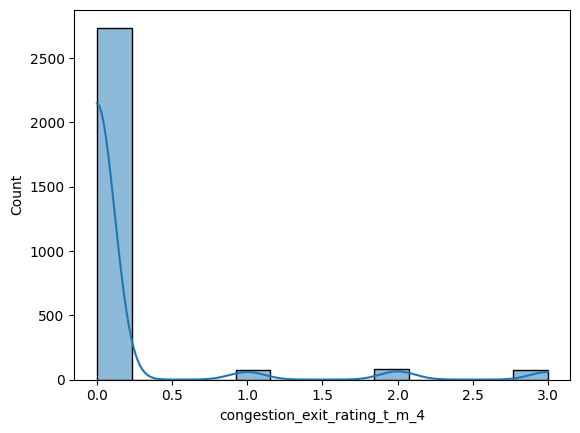

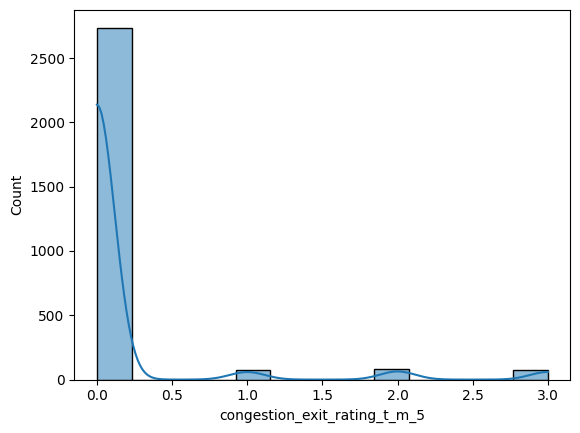

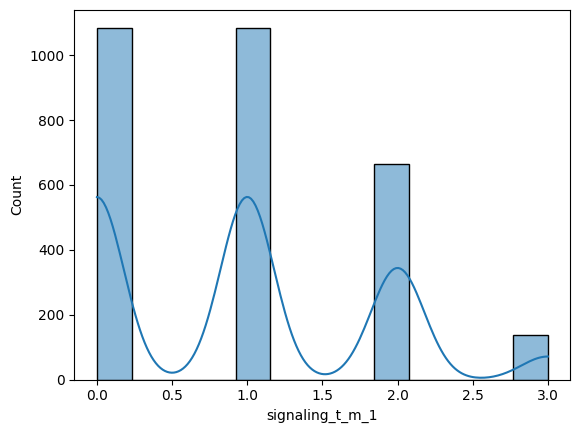

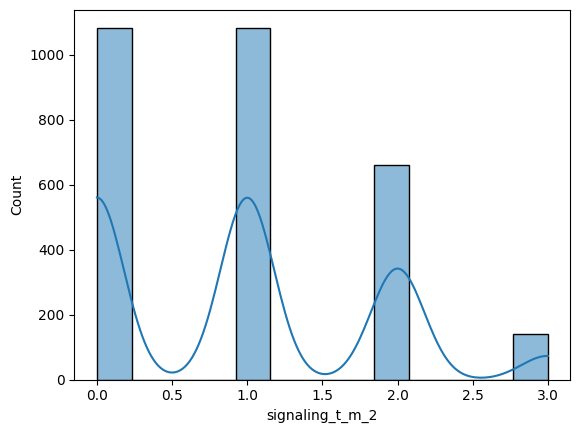

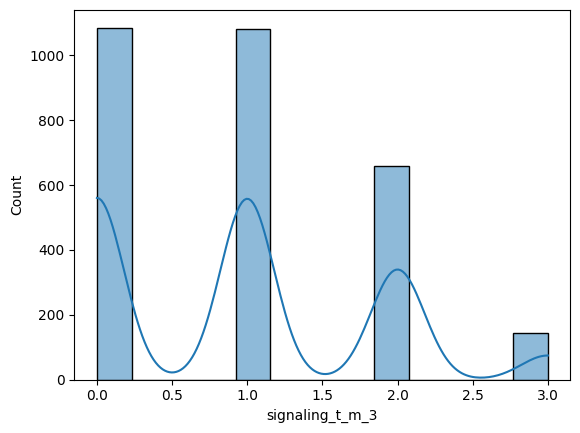

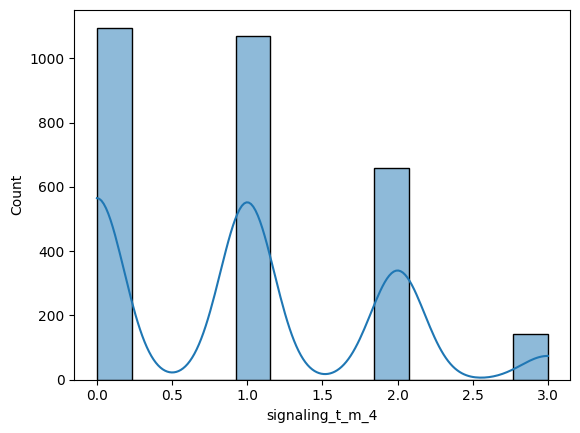

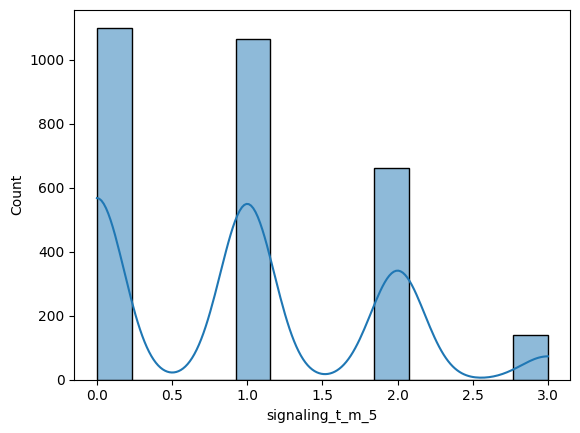

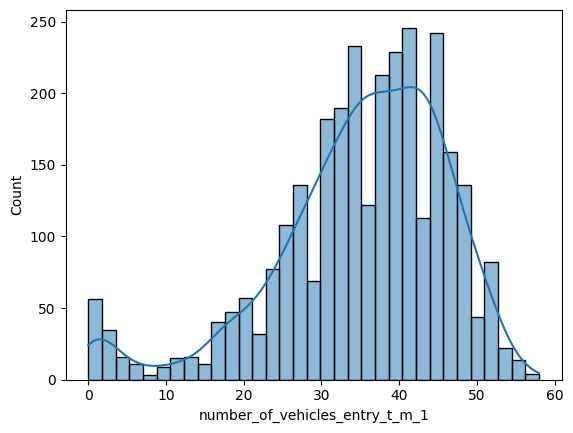

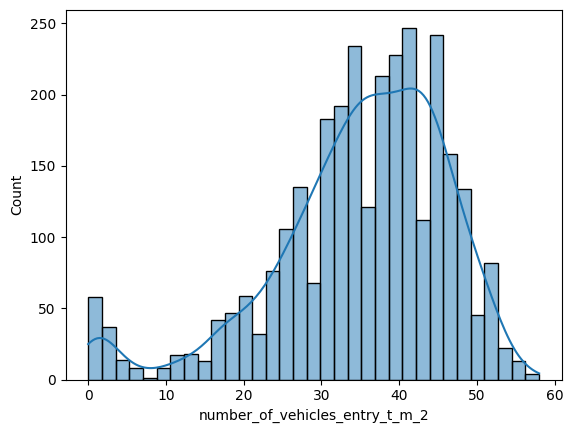

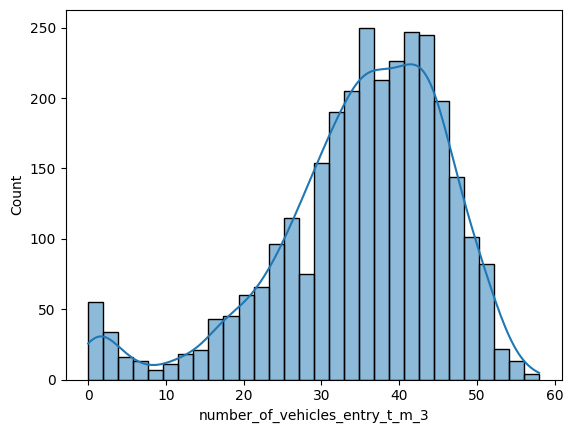

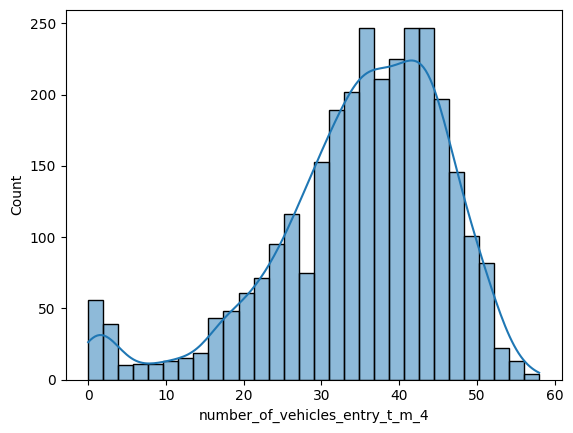

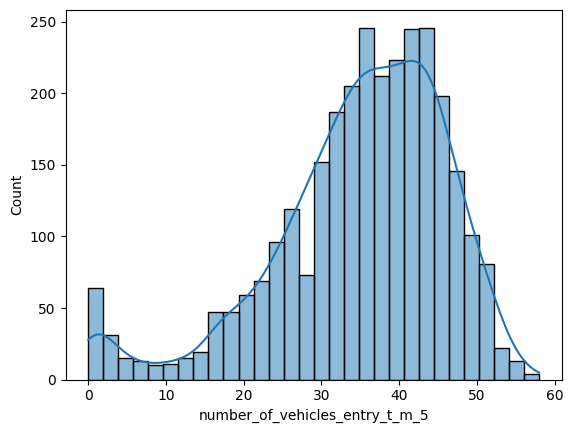

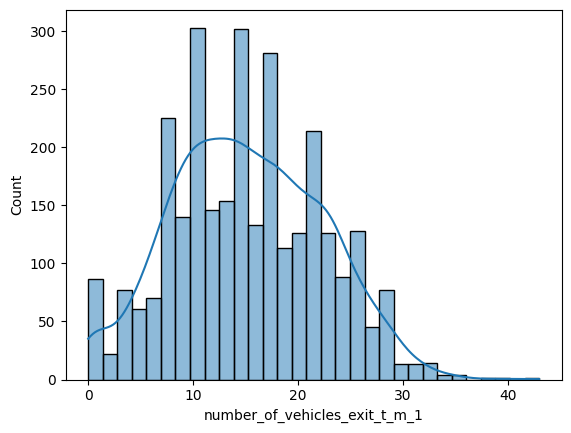

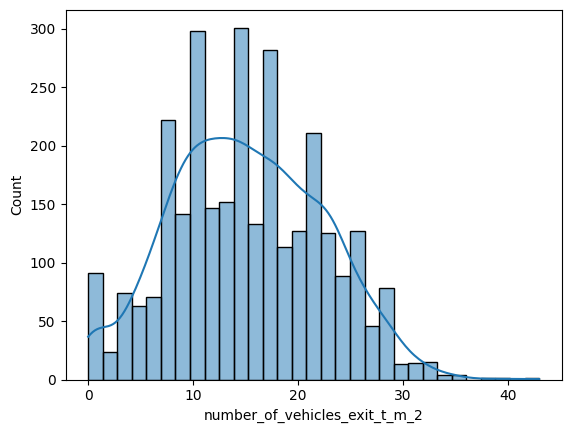

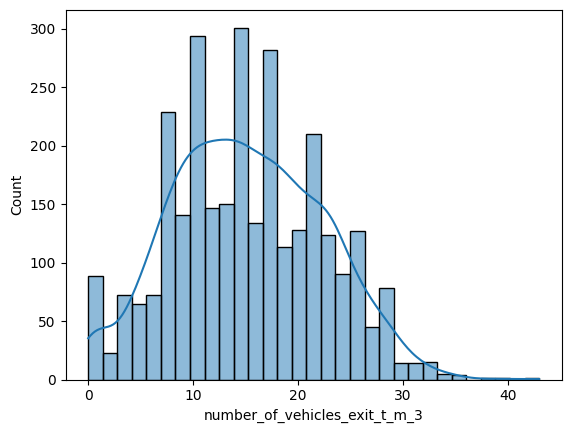

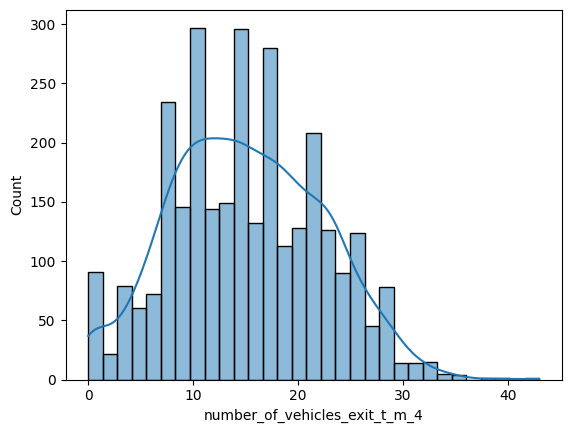

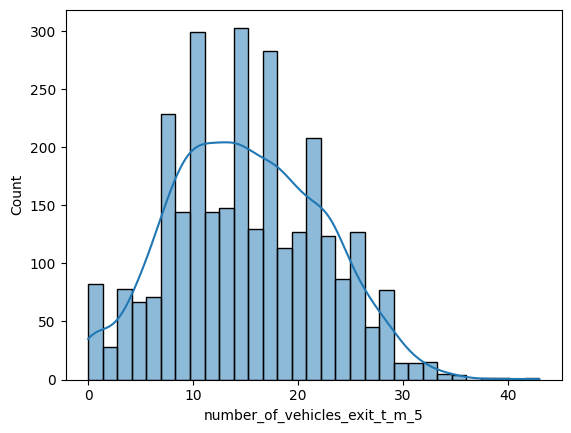

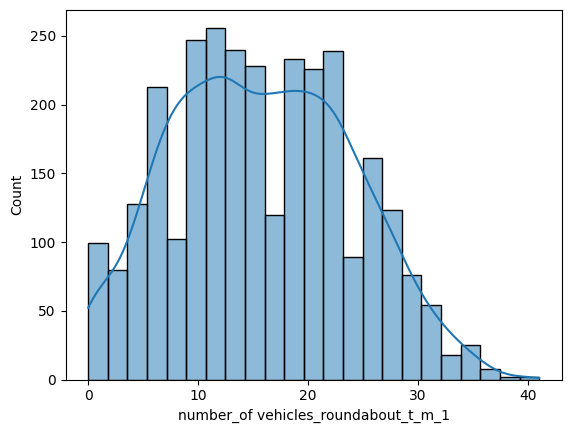

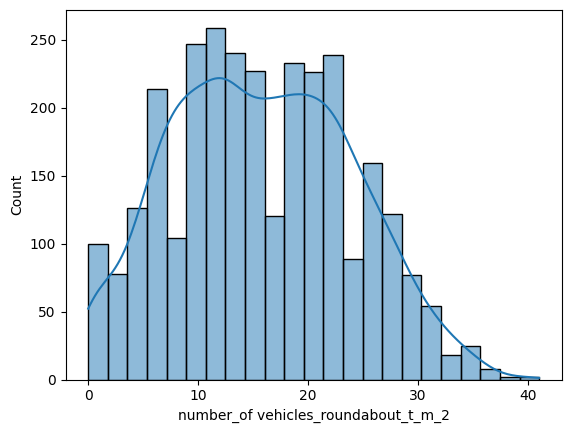

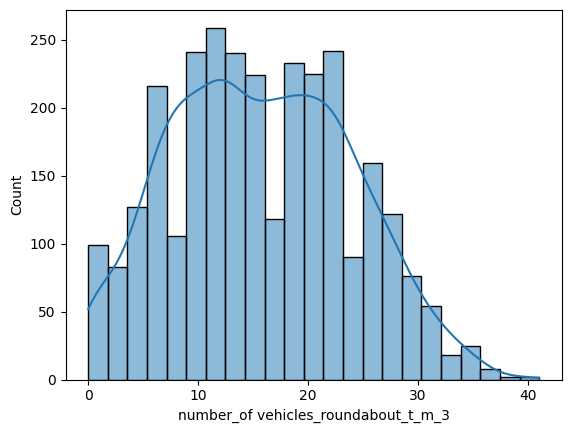

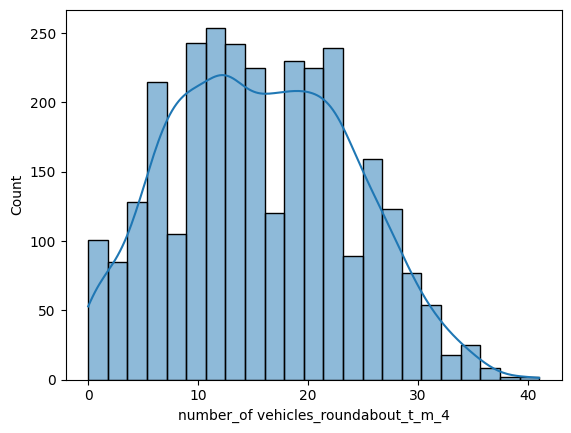

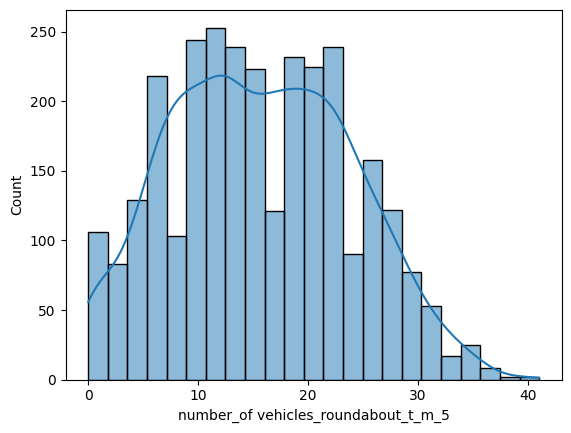

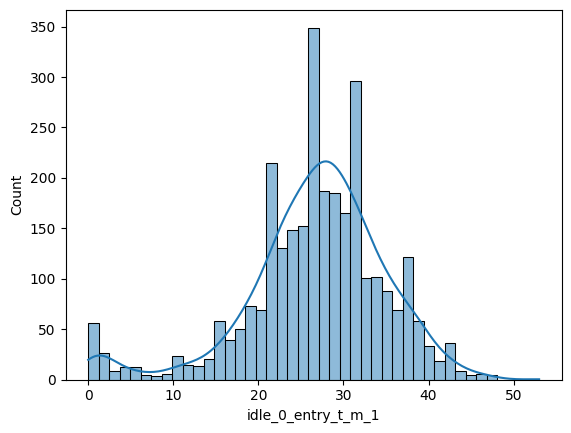

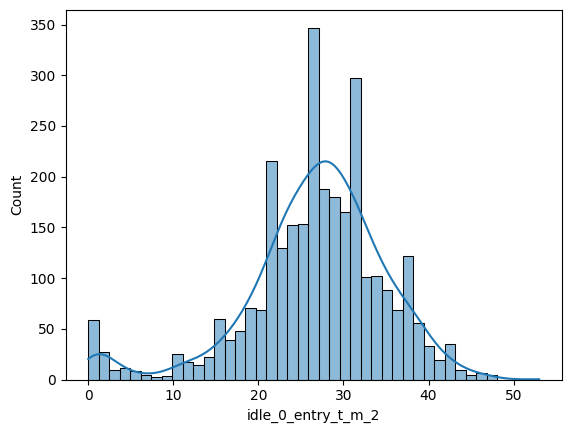

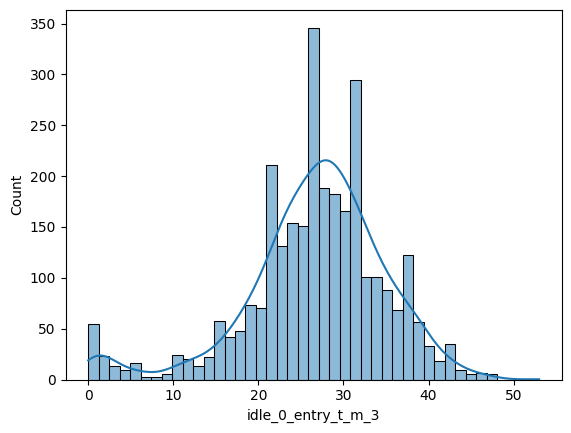

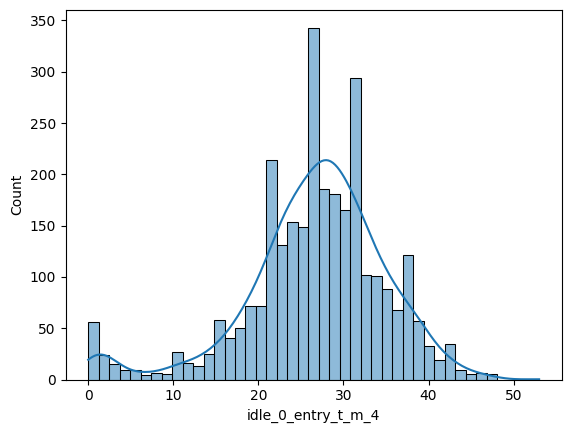

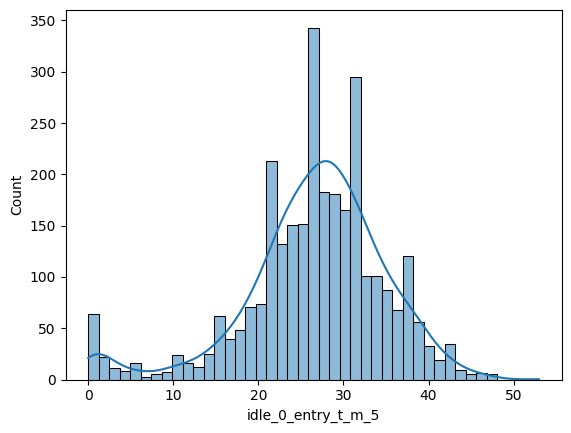

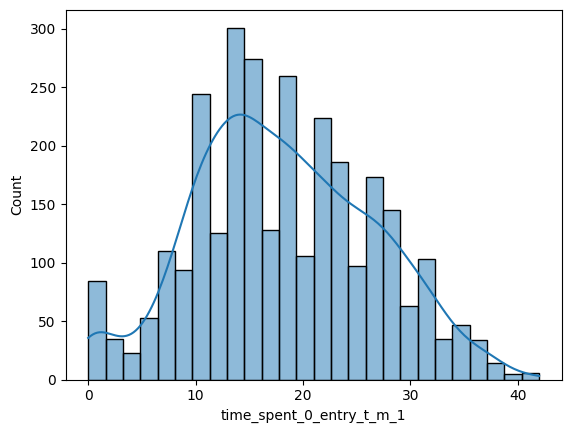

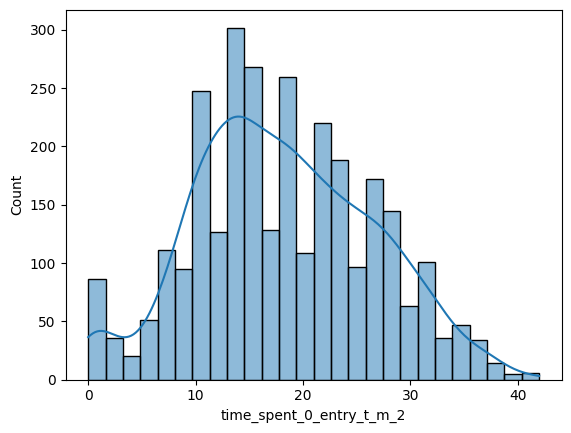

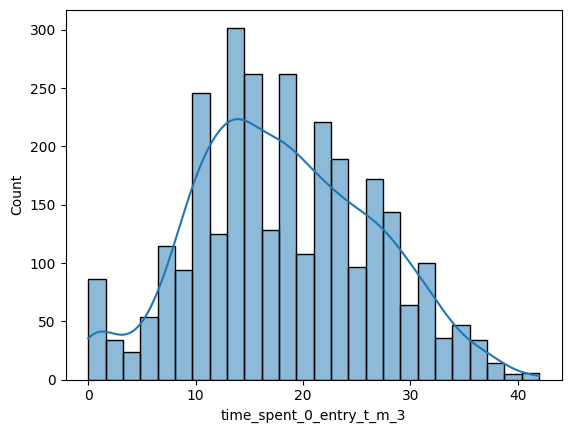

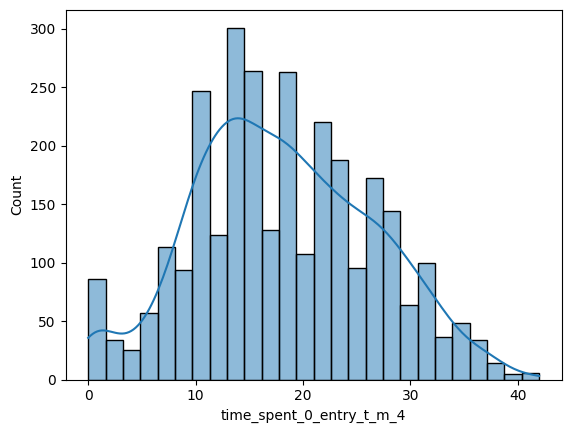

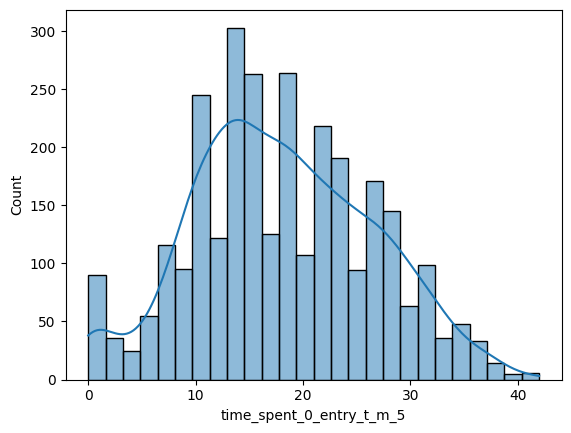

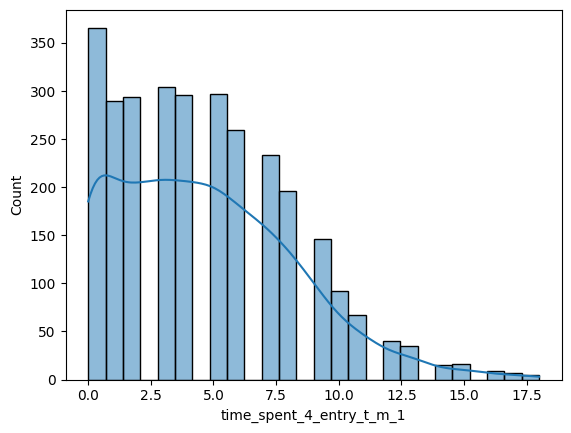

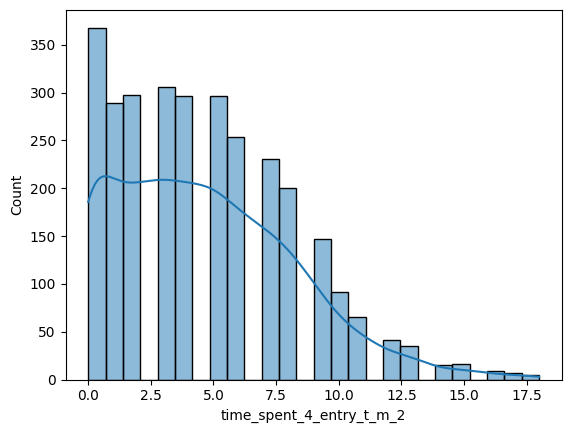

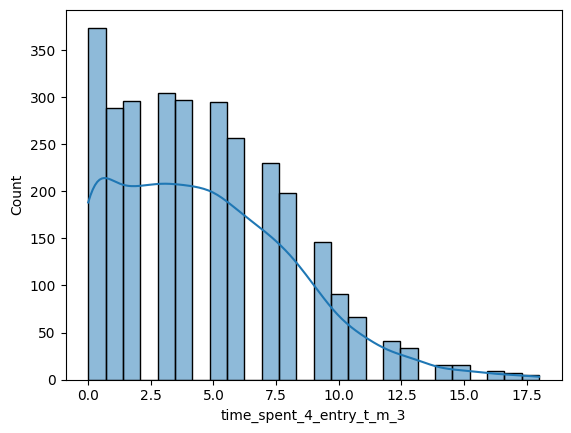

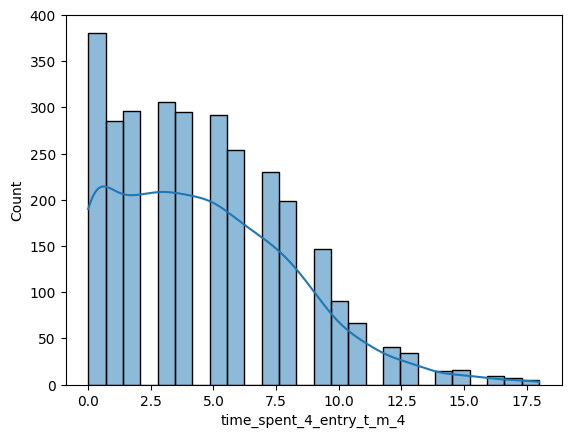

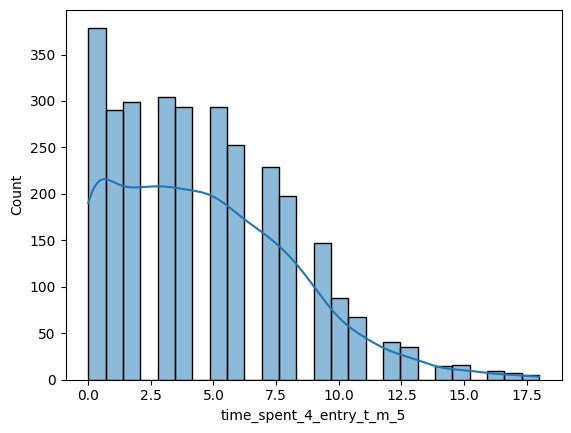

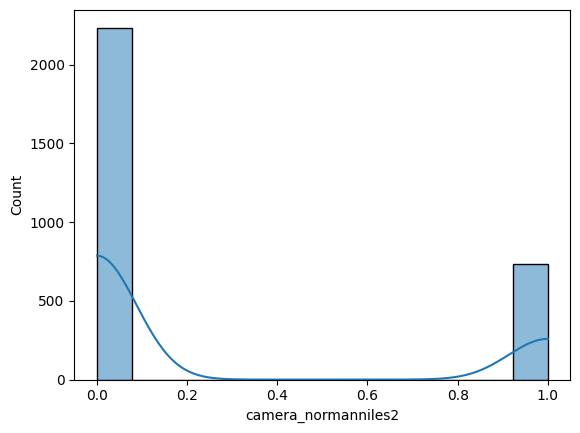

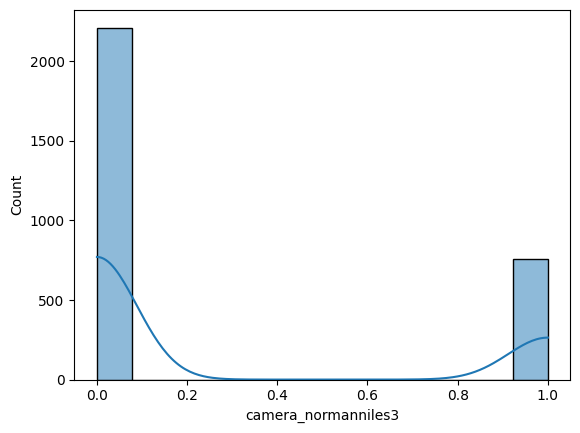

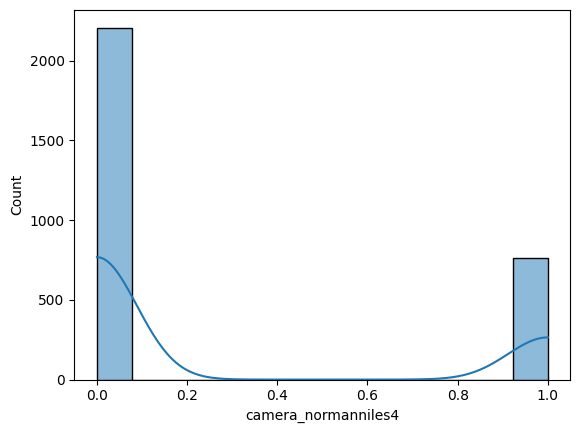

In [23]:
for col in X.columns:
  sns.histplot(x=X[col], kde=True)
  plt.show()

In [24]:
def f1_macro_eval(preds, train_data):
    labels = train_data.get_label().astype(int)
    num_class = int(train_data.params["num_class"])

    preds = preds.reshape(len(labels), num_class)
    y_pred = preds.argmax(axis=1)

    f1 = f1_score(labels, y_pred, average="macro")
    return "f1_macro", f1, True

def accuracy_eval(preds, train_data):
    labels = train_data.get_label().astype(int)
    num_class = int(train_data.params["num_class"])

    preds = preds.reshape(len(labels), num_class)
    y_pred = preds.argmax(axis=1)

    f1 = accuracy_score(labels, y_pred)
    return "accuracy", f1, True

# LightGBM


LightGBM CLASSIFIER: 5 Windows x 5 Targets
Features: 92 | Samples: 2969

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 1.24315
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 1.28328
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 1.25075
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	valid_0's multi_logloss: 1.19351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 1.18922
Window 01: Acc=0.4490 | F1-Macro=0.2508
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 1.20635
Training until validation scores don't improve for 50 rounds
Early stopping, best 

/tmp/ipython-input-3447869314.py:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=global_importance.head(20), x='importance', y='feature', palette='rocket')


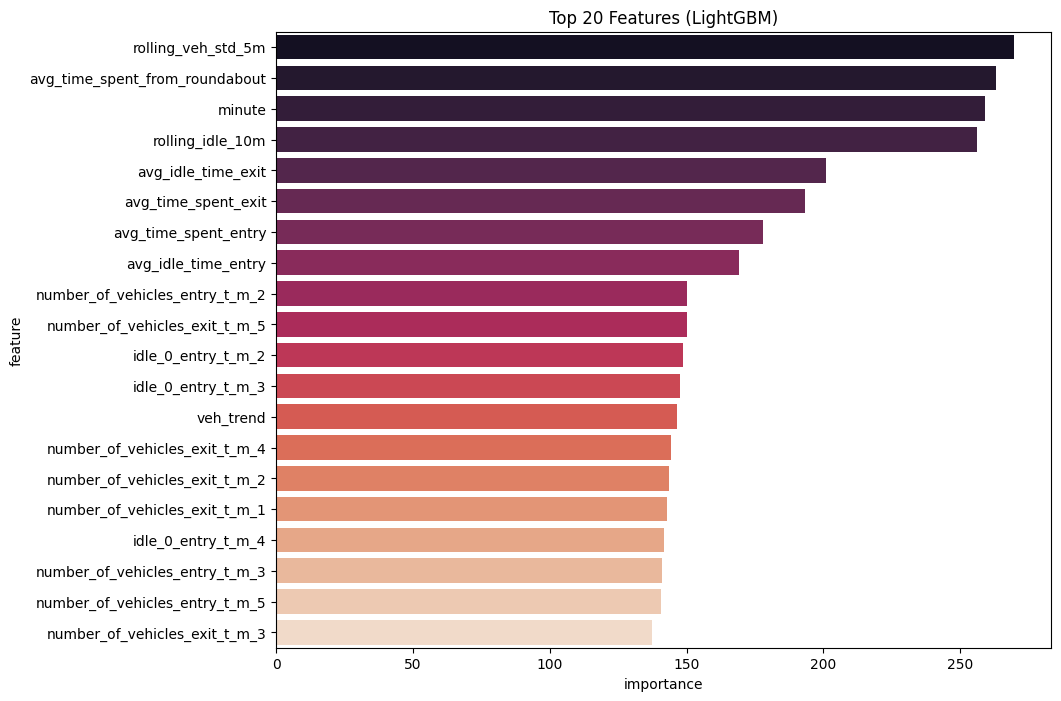

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score

model_config = {
    'n_estimators': 2000,
    'learning_rate': 0.03,        
    'num_leaves': 31,             
    'min_child_samples': 20,      
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'class_weight': 'balanced',   
    'reg_alpha': 0.1,             
    'reg_lambda': 0.1,            
    'random_state': 42,
    'n_jobs': -1,                 
    'verbose': -1                 
}

# FEATURE ENGINEERING
X = X.copy()

X['congestion_diff'] = X['congestion_enter_rating'] - X['congestion_enter_rating_t_m_1']

X['veh_accel'] = X['number_of_vehicles_entry'] - X['number_of_vehicles_entry_t_m_1']

# Volatility: Rolling standard deviation
X['rolling_veh_std_5m'] = X['number_of_vehicles_entry'].rolling(window=5).std().fillna(0)
X['rolling_idle_10m'] = X['idle_0_entry'].rolling(window=10).mean().fillna(0)

X['is_rush_hour'] = X['hour'].apply(lambda x: 1 if x in [7,8,9,16,17,18] else 0)

X['rush_and_busy'] = X['is_rush_hour'] * (X['number_of_vehicles_entry'] > X['number_of_vehicles_entry'].mean()).astype(int)


#  SETUP
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
target_cols = y_enter.columns.tolist()

model_dir = 'lightgbm_traffic_analysis'
os.makedirs(model_dir, exist_ok=True)

fold_results = []
all_importances = []

print(f"\n{'='*75}")
print(f"LightGBM CLASSIFIER: {n_splits} Windows x {len(target_cols)} Targets")
print(f"Features: {X.shape[1]} | Samples: {X.shape[0]}")
print(f"{'='*75}\n")

# TRAINING LOOP
fold_num = 0
for train_idx, val_idx in tscv.split(X):
    fold_num += 1

    X_train_fold, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_df = y_enter.iloc[train_idx], y_enter.iloc[val_idx]

    all_target_preds = []
    fold_path = os.path.join(model_dir, f'fold_{fold_num}')
    os.makedirs(fold_path, exist_ok=True)

    for col in target_cols:

        model = LGBMClassifier(**model_config)

        model.fit(
            X_train_fold, y_train_fold[col],
            eval_set=[(X_val, y_val_df[col])],
            callbacks=[
                early_stopping(stopping_rounds=50),
                log_evaluation(period=0)  
            ]
        )

        model.booster_.save_model(os.path.join(fold_path, f'model_{col}.txt'))
        all_target_preds.append(model.predict(X_val))

        imp_df = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_,
            'target': col,
            'fold': fold_num
        })
        all_importances.append(imp_df)

    # EVALUATION
    y_pred_final = np.column_stack(all_target_preds)
    y_val_flat = y_val_df.to_numpy().flatten()
    y_pred_flat = y_pred_final.flatten()

    fold_acc = accuracy_score(y_val_flat, y_pred_flat)
    fold_f1_macro = f1_score(y_val_flat, y_pred_flat, average="macro", zero_division=0)

    fold_results.append({"fold": fold_num, "accuracy": fold_acc, "f1_macro": fold_f1_macro})
    print(f"Window {fold_num:02d}: Acc={fold_acc:.4f} | F1-Macro={fold_f1_macro:.4f}")

# SUMMARY
fold_df = pd.DataFrame(fold_results)
total_importance_df = pd.concat(all_importances)
global_importance = total_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False).reset_index()

config_to_save = model_config.copy()

metadata = {
    'model_type': 'LGBMClassifier',
    'timestamp': datetime.now().isoformat(),
    'n_folds': n_splits,
    'mean_accuracy': float(fold_df['accuracy'].mean()),
    'std_accuracy': float(fold_df['accuracy'].std()),
    'mean_f1_macro': float(fold_df['f1_macro'].mean()),
    'top_5_features': global_importance['feature'].head(5).tolist(),
    'model_config': config_to_save,
}

with open(os.path.join(model_dir, 'summary_metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"\n{'-'*75}")
print(f"FINAL MEAN RESULTS (LightGBM)")
print(f"Accuracy: {fold_df['accuracy'].mean():.4f}")
print(f"F1-Macro: {fold_df['f1_macro'].mean():.4f}")
print(f"{'-'*75}\n")

# Plot Top Features
plt.figure(figsize=(10, 8))
sns.barplot(data=global_importance.head(20), x='importance', y='feature', palette='rocket')
plt.title('Top 20 Features (LightGBM)')
plt.show()

In [41]:
!zip -r lightgbm_traffic_analysis.zip lightgbm_traffic_analysis

  adding: lightgbm_traffic_analysis/ (stored 0%)
  adding: lightgbm_traffic_analysis/fold_1/ (stored 0%)
  adding: lightgbm_traffic_analysis/fold_1/model_congestion_enter_rating_t_1.txt (deflated 63%)
  adding: lightgbm_traffic_analysis/fold_1/model_congestion_enter_rating_t_5.txt (deflated 63%)
  adding: lightgbm_traffic_analysis/fold_1/model_congestion_enter_rating_t_2.txt (deflated 63%)
  adding: lightgbm_traffic_analysis/fold_1/model_congestion_enter_rating_t_3.txt (deflated 63%)
  adding: lightgbm_traffic_analysis/fold_1/model_congestion_enter_rating_t_4.txt (deflated 63%)
  adding: lightgbm_traffic_analysis/fold_5/ (stored 0%)
  adding: lightgbm_traffic_analysis/fold_5/model_congestion_enter_rating_t_1.txt (deflated 61%)
  adding: lightgbm_traffic_analysis/fold_5/model_congestion_enter_rating_t_5.txt (deflated 61%)
  adding: lightgbm_traffic_analysis/fold_5/model_congestion_enter_rating_t_2.txt (deflated 61%)
  adding: lightgbm_traffic_analysis/fold_5/model_congestion_enter_ratin

# Removed SMOTE & added sample weight


XGBoost: 5 Windows x 5 Targets
Features: 91 | Samples: 2969

Window 01: Acc=0.3960 | F1-Macro=0.2564
Window 02: Acc=0.3939 | F1-Macro=0.3388
Window 03: Acc=0.5810 | F1-Macro=0.4187
Window 04: Acc=0.3279 | F1-Macro=0.3140
Window 05: Acc=0.4364 | F1-Macro=0.4162

---------------------------------------------------------------------------
FINAL MEAN RESULTS
Accuracy: 0.4270
F1-Macro: 0.3488
---------------------------------------------------------------------------



/tmp/ipython-input-3229248955.py:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=global_importance.head(20), x='importance', y='feature', palette='rocket')


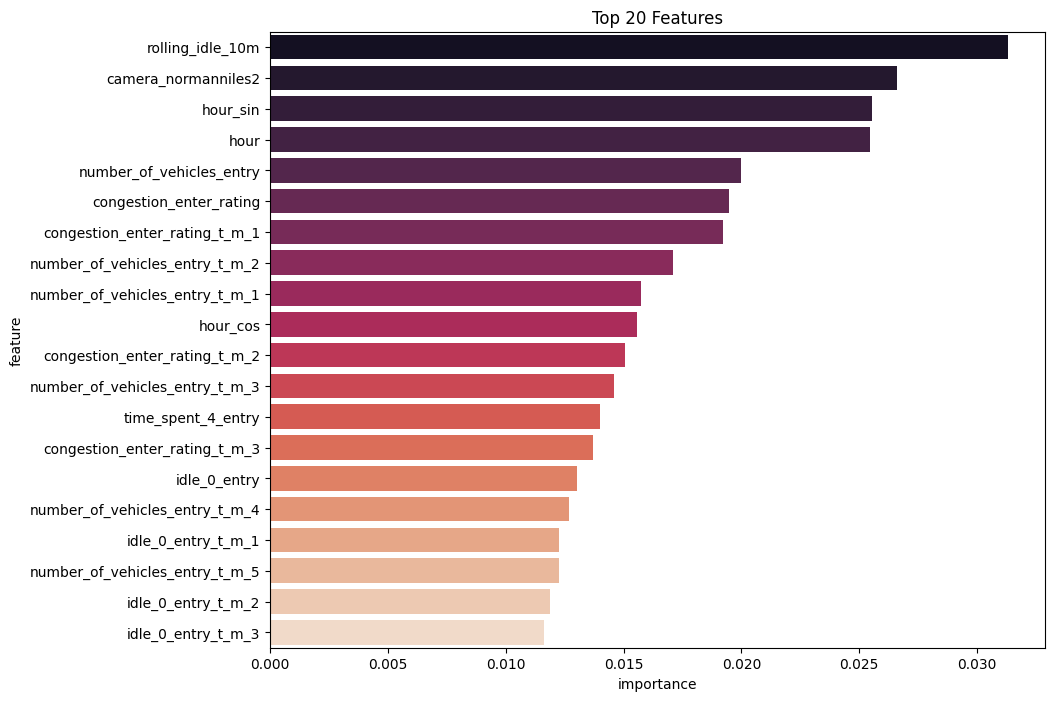

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight

model_config = {
        'n_estimators': 1500,
        'learning_rate': 0.02,
        'max_depth': 6,
        'min_child_weight': 5,
        'max_delta_step': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'early_stopping_rounds': 50,
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'random_state': 42,
        'tree_method': 'hist',
        'gamma': 0.2,
    }

# FEATURE ENGINEERING 
X = X.copy()

X['congestion_diff'] = X['congestion_enter_rating'] - X['congestion_enter_rating_t_m_1']

X['veh_accel'] = X['number_of_vehicles_entry'] - X['number_of_vehicles_entry_t_m_1']

X['rolling_veh_std_5m'] = X['number_of_vehicles_entry'].rolling(window=5).std().fillna(0)

X['rolling_idle_10m'] = X['idle_0_entry'].rolling(window=10).mean().fillna(0)

X['is_rush_hour'] = X['hour'].apply(lambda x: 1 if x in [7,8,9,16,17,18] else 0)

# Setup & Configuration
n_splits = 5 
tscv = TimeSeriesSplit(n_splits=n_splits)
target_cols = y_enter.columns.tolist()

model_dir = 'xgboost_classifier_optimized'
os.makedirs(model_dir, exist_ok=True)

fold_results = []
all_importances = []

print(f"\n{'='*75}")
print(f"XGBoost: {n_splits} Windows x {len(target_cols)} Targets")
print(f"Features: {X.shape[1]} | Samples: {X.shape[0]}")
print(f"{'='*75}\n")

# Training Loop
fold_num = 0
for train_idx, val_idx in tscv.split(X):
    fold_num += 1

    X_train_fold, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_df = y_enter.iloc[train_idx], y_enter.iloc[val_idx]

    all_target_preds = []
    fold_path = os.path.join(model_dir, f'fold_{fold_num}')
    os.makedirs(fold_path, exist_ok=True)

    for col in target_cols:
        weights = compute_sample_weight(class_weight='balanced', y=y_train_fold[col])
        val_weights = compute_sample_weight(class_weight='balanced', y=y_val_df[col])

        model = XGBClassifier(
            **model_config
        )

        model.fit(
            X_train_fold, y_train_fold[col],
            sample_weight=weights,
            eval_set=[(X_val, y_val_df[col])],
            sample_weight_eval_set=[val_weights],
            verbose=False
        )

        # Predict
        all_target_preds.append(model.predict(X_val))

        # Save Model
        model.save_model(os.path.join(fold_path, f'model_{col}.json'))

        # Capture Importance
        imp_df = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_,
            'target': col,
            'fold': fold_num
        })
        all_importances.append(imp_df)

    # Evaluation
    y_pred_final = np.column_stack(all_target_preds)
    y_val_flat = y_val_df.to_numpy().flatten()
    y_pred_flat = y_pred_final.flatten()

    fold_acc = accuracy_score(y_val_flat, y_pred_flat)
    fold_f1_macro = f1_score(y_val_flat, y_pred_flat, average="macro", zero_division=0)

    fold_results.append({"fold": fold_num, "accuracy": fold_acc, "f1_macro": fold_f1_macro})
    print(f"Window {fold_num:02d}: Acc={fold_acc:.4f} | F1-Macro={fold_f1_macro:.4f}")

# Aggregation & Summary
fold_df = pd.DataFrame(fold_results)
total_importance_df = pd.concat(all_importances)
global_importance = total_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False).reset_index()

metadata = {
    'model_type': 'XGBoostClassifier',
    'timestamp': datetime.now().isoformat(),
    'n_folds': n_splits,
    'mean_accuracy': float(fold_df['accuracy'].mean()),
    'std_accuracy': float(fold_df['accuracy'].std()),
    'mean_f1_macro': float(fold_df['f1_macro'].mean()),
    'top_5_features': global_importance['feature'].head(5).tolist(),
    'model_config': model_config,
}

with open(os.path.join(model_dir, 'summary_metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"\n{'-'*75}")
print(f"FINAL MEAN RESULTS")
print(f"Accuracy: {fold_df['accuracy'].mean():.4f}")
print(f"F1-Macro: {fold_df['f1_macro'].mean():.4f}")
print(f"{'-'*75}\n")

# Plot Top Features
plt.figure(figsize=(10, 8))
sns.barplot(data=global_importance.head(20), x='importance', y='feature', palette='rocket')
plt.title('Top 20 Features')
plt.show()

In [36]:
!zip -r compute_sample_weight_removedSMOTE_changed_loss.zip compute_sample_weight_removedSMOTE

  adding: compute_sample_weight_removedSMOTE/ (stored 0%)
  adding: compute_sample_weight_removedSMOTE/fold_1/ (stored 0%)
  adding: compute_sample_weight_removedSMOTE/fold_1/model_congestion_enter_rating_t_1.json (deflated 75%)
  adding: compute_sample_weight_removedSMOTE/fold_1/model_congestion_enter_rating_t_3.json (deflated 75%)
  adding: compute_sample_weight_removedSMOTE/fold_1/model_congestion_enter_rating_t_5.json (deflated 75%)
  adding: compute_sample_weight_removedSMOTE/fold_1/model_congestion_enter_rating_t_4.json (deflated 76%)
  adding: compute_sample_weight_removedSMOTE/fold_1/model_congestion_enter_rating_t_2.json (deflated 75%)
  adding: compute_sample_weight_removedSMOTE/fold_5/ (stored 0%)
  adding: compute_sample_weight_removedSMOTE/fold_5/model_congestion_enter_rating_t_1.json (deflated 75%)
  adding: compute_sample_weight_removedSMOTE/fold_5/model_congestion_enter_rating_t_3.json (deflated 75%)
  adding: compute_sample_weight_removedSMOTE/fold_5/model_congestion_e

# TimeSeriesSplit + SMOTE


XGBoost + SMOTE TIME-SERIES: 5 Windows x 5 Targets
Features: 88 | Samples: 2969

Window 01: Acc=0.4866 | F1-Macro=0.2570
Window 02: Acc=0.4368 | F1-Macro=0.3415
Window 03: Acc=0.5854 | F1-Macro=0.3977
Window 04: Acc=0.3866 | F1-Macro=0.3218
Window 05: Acc=0.5000 | F1-Macro=0.4138

---------------------------------------------------------------------------
FINAL MEAN RESULTS (SMOTE + TIME-SERIES)
Accuracy: 0.4791
F1-Macro: 0.3463
---------------------------------------------------------------------------



/tmp/ipython-input-3075189265.py:147: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=global_importance.head(20), x='importance', y='feature', palette='rocket')


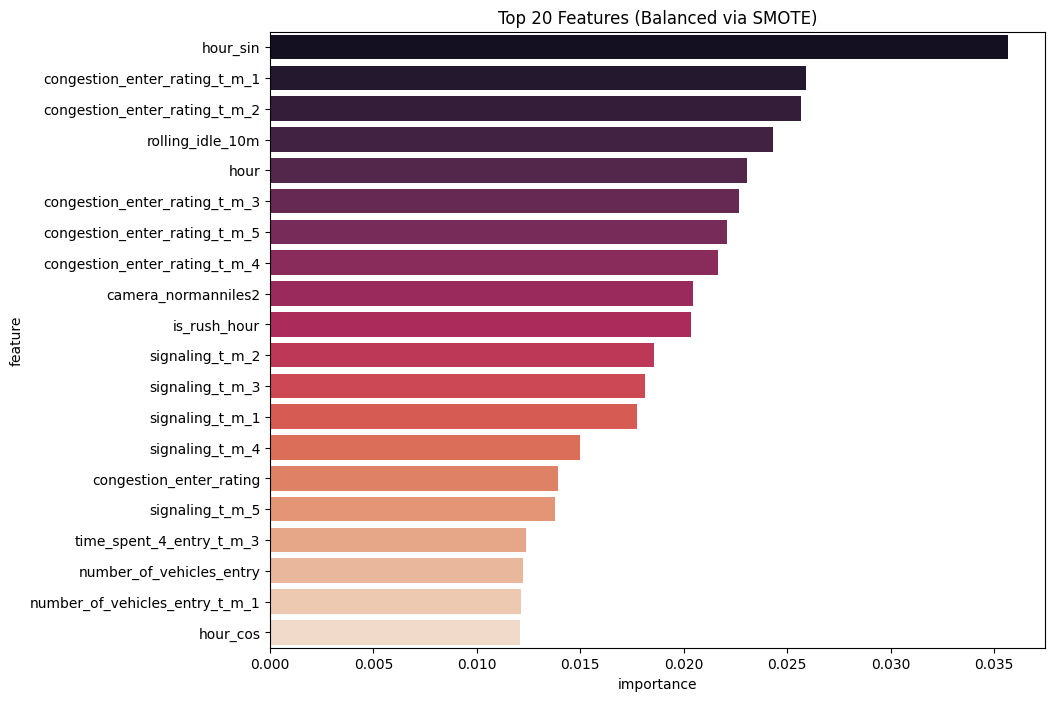

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score
# from imblearn.over_sampling import SMOTE

model_config = {
        'n_estimators': 2000,
        'learning_rate': 0.05,
        'max_depth': 5,
        'min_child_weight': 1,
        'max_delta_step': 5,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'early_stopping_rounds': 50,
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'random_state': 42,
        'tree_method': 'hist',
        'gamma': 0.1,
    }

# FEATURE ENGINEERING
X = X.copy()
X['rolling_idle_10m'] = X['idle_0_entry'].rolling(window=10).mean().fillna(0)

X['is_rush_hour'] = X['hour'].apply(lambda x: 1 if x in [7,8,9,16,17,18] else 0)

# Setup & Configuration
n_splits = 5 
tscv = TimeSeriesSplit(n_splits=n_splits)
target_cols = y_enter.columns.tolist()

# SMOTE configuration
# k_neighbors is small because your dataset is small (~1100 samples)
# smote = SMOTE(random_state=42, k_neighbors=5)

model_dir = 'traffic_smote_analysis'
os.makedirs(model_dir, exist_ok=True)

fold_results = []
all_importances = []

print(f"\n{'='*75}")
print(f"XGBoost + SMOTE TIME-SERIES: {n_splits} Windows x {len(target_cols)} Targets")
print(f"Features: {X.shape[1]} | Samples: {X.shape[0]}")
print(f"{'='*75}\n")

# Training Loop 
fold_num = 0
for train_idx, val_idx in tscv.split(X):
    fold_num += 1

    X_train_fold, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_df = y_enter.iloc[train_idx], y_enter.iloc[val_idx]

    all_target_preds = []
    fold_path = os.path.join(model_dir, f'fold_{fold_num}')
    os.makedirs(fold_path, exist_ok=True)

    for col in target_cols:
        # try:
        #     X_resampled, y_resampled = smote.fit_resample(X_train_fold, y_train_fold[col])
        # except ValueError:
        X_resampled, y_resampled = X_train_fold, y_train_fold[col]
            # print(f"Warning: SMOTE skipped for {col} in Fold {fold_num} (too few samples).")

        model = XGBClassifier(
            **model_config
        )

        model.fit(
            X_resampled, y_resampled,
            eval_set=[(X_val, y_val_df[col])],
            verbose=False
        )

        # D. Save & Predict
        model.save_model(os.path.join(fold_path, f'model_{col}.json'))
        all_target_preds.append(model.predict(X_val))

        # Capture Importance
        imp_df = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_,
            'target': col,
            'fold': fold_num
        })
        all_importances.append(imp_df)

    # Evaluation
    y_pred_final = np.column_stack(all_target_preds)
    y_val_flat = y_val_df.to_numpy().flatten()
    y_pred_flat = y_pred_final.flatten()

    fold_acc = accuracy_score(y_val_flat, y_pred_flat)
    fold_f1_macro = f1_score(y_val_flat, y_pred_flat, average="macro", zero_division=0)

    fold_results.append({"fold": fold_num, "accuracy": fold_acc, "f1_macro": fold_f1_macro})
    print(f"Window {fold_num:02d}: Acc={fold_acc:.4f} | F1-Macro={fold_f1_macro:.4f}")

# Aggregation & Summary
fold_df = pd.DataFrame(fold_results)
total_importance_df = pd.concat(all_importances)
global_importance = total_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False).reset_index()

metadata = {
    'model_type': 'XGBoostClassifier',
    'timestamp': datetime.now().isoformat(),
    'n_folds': n_splits,
    'mean_accuracy': float(fold_df['accuracy'].mean()),
    'std_accuracy': float(fold_df['accuracy'].std()),
    'mean_f1_macro': float(fold_df['f1_macro'].mean()),
    'top_5_features': global_importance['feature'].head(5).tolist(),
    'model_config': model_config,
}

with open(os.path.join(model_dir, 'summary_metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"\n{'-'*75}")
print(f"FINAL MEAN RESULTS (SMOTE + TIME-SERIES)")
print(f"Accuracy: {fold_df['accuracy'].mean():.4f}")
print(f"F1-Macro: {fold_df['f1_macro'].mean():.4f}")
print(f"{'-'*75}\n")

# Plot Top Features
plt.figure(figsize=(10, 8))
sns.barplot(data=global_importance.head(20), x='importance', y='feature', palette='rocket')
plt.title('Top 20 Features (Balanced via SMOTE)')
plt.show()

In [31]:
!zip -r updated_yolo_traffic_smote_analysis.zip traffic_smote_analysis

updating: traffic_smote_analysis/ (stored 0%)
updating: traffic_smote_analysis/fold_1/ (stored 0%)
updating: traffic_smote_analysis/fold_1/model_congestion_enter_rating_t_1.json (deflated 73%)
updating: traffic_smote_analysis/fold_1/model_congestion_enter_rating_t_3.json (deflated 73%)
updating: traffic_smote_analysis/fold_1/model_congestion_enter_rating_t_5.json (deflated 73%)
updating: traffic_smote_analysis/fold_1/model_congestion_enter_rating_t_4.json (deflated 73%)
updating: traffic_smote_analysis/fold_1/model_congestion_enter_rating_t_2.json (deflated 73%)
updating: traffic_smote_analysis/fold_5/ (stored 0%)
updating: traffic_smote_analysis/fold_5/model_congestion_enter_rating_t_1.json (deflated 73%)
updating: traffic_smote_analysis/fold_5/model_congestion_enter_rating_t_3.json (deflated 73%)
updating: traffic_smote_analysis/fold_5/model_congestion_enter_rating_t_5.json (deflated 73%)
updating: traffic_smote_analysis/fold_5/model_congestion_enter_rating_t_4.json (deflated 73%)
up

# Time Series Split


XGBoost TIME-SERIES Training: 5 Windows x 5 Time Steps
Features: 84 | Samples: 1178

Window 01: Accuracy=0.5959 | F1-Macro=0.2854
Window 02: Accuracy=0.5245 | F1-Macro=0.2327
Window 03: Accuracy=0.5673 | F1-Macro=0.3126
Window 04: Accuracy=0.4622 | F1-Macro=0.2678
Window 05: Accuracy=0.5459 | F1-Macro=0.3741

---------------------------------------------------------------------------
TIME-SERIES CROSS-VALIDATION RESULTS
Mean Accuracy: 0.5392
Mean F1-Macro: 0.2945
---------------------------------------------------------------------------



/tmp/ipython-input-4235722242.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=global_importance.head(20), x='importance', y='feature', palette='viridis')


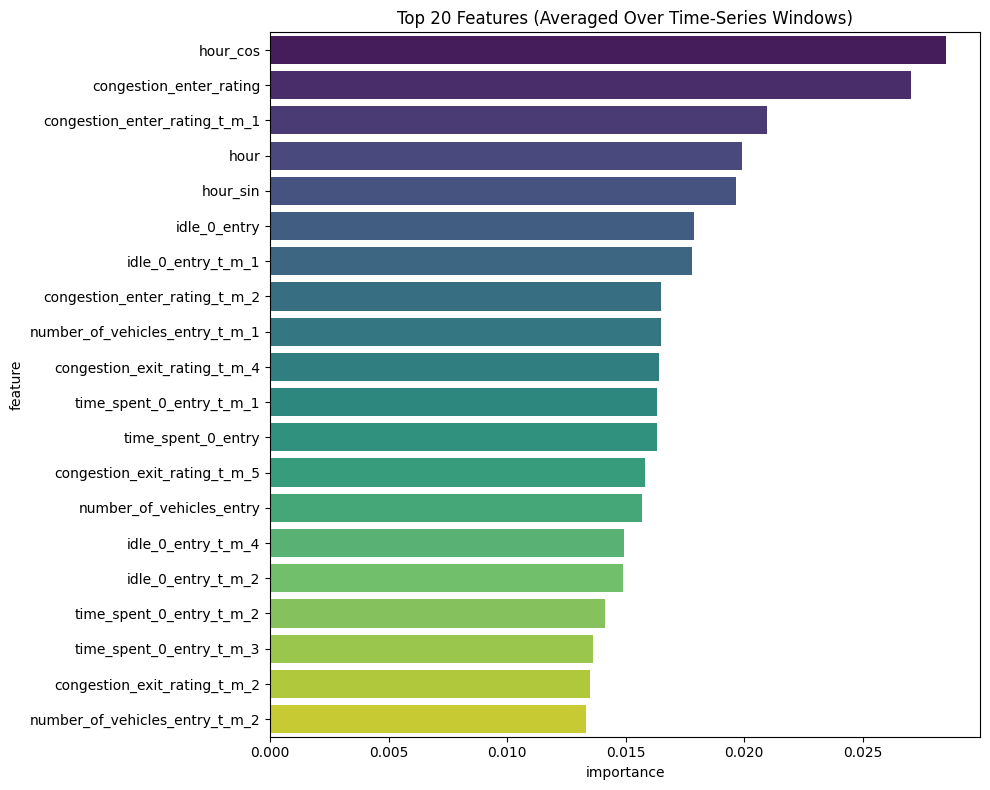

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, f1_score


n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
target_cols = y_enter.columns.tolist()

model_dir = 'traffic_timeseries_analysis'
os.makedirs(model_dir, exist_ok=True)

fold_results = []
all_importances = []

weights = compute_sample_weight(class_weight='balanced', y=y_enter[target_cols[0]])

print(f"\n{'='*75}")
print(f"XGBoost TIME-SERIES Training: {n_splits} Windows x {len(target_cols)} Time Steps")
print(f"Features: {X.shape[1]} | Samples: {X.shape[0]}")
print(f"{'='*75}\n")

# 2. Training Loop
fold_num = 0
for train_idx, val_idx in tscv.split(X):
    fold_num += 1

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train_df, y_val_df = y_enter.iloc[train_idx], y_enter.iloc[val_idx]

    train_weights = weights[train_idx]

    all_target_preds = []

    fold_path = os.path.join(model_dir, f'fold_{fold_num}')
    os.makedirs(fold_path, exist_ok=True)

    for col in target_cols:
        model = XGBClassifier(
            n_estimators=2000,
            learning_rate=0.01,
            max_depth=6,
            early_stopping_rounds=50,
            objective='multi:softprob',
            eval_metric='mlogloss',
            random_state=42,
            tree_method='hist',
            subsample=0.8,
            colsample_bytree=0.8,
            max_delta_step=2 
        )

        model.fit(
            X_train, y_train_df[col],
            sample_weight=train_weights,
            eval_set=[(X_val, y_val_df[col])], 
            verbose=False
        )

        imp_df = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_,
            'target': col,
            'fold': fold_num
        })
        all_importances.append(imp_df)

        model.save_model(os.path.join(fold_path, f'model_{col}.json'))

        all_target_preds.append(model.predict(X_val))

    y_pred_final = np.column_stack(all_target_preds)
    y_val_flat = y_val_df.to_numpy().flatten()
    y_pred_flat = y_pred_final.flatten()

    fold_acc = accuracy_score(y_val_flat, y_pred_flat)
    fold_f1_macro = f1_score(y_val_flat, y_pred_flat, average="macro", zero_division=0)

    fold_results.append({
        "fold": fold_num,
        "accuracy": fold_acc,
        "f1_macro": fold_f1_macro
    })

    print(f"Window {fold_num:02d}: Accuracy={fold_acc:.4f} | F1-Macro={fold_f1_macro:.4f}")

# Final Aggregation

total_importance_df = pd.concat(all_importances)
global_importance = total_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False).reset_index()
global_importance.to_csv(os.path.join(model_dir, 'global_importance.csv'), index=False)

fold_df = pd.DataFrame(fold_results)
fold_df.to_csv(os.path.join(model_dir, 'cv_metrics.csv'), index=False)

print(f"\n{'-'*75}")
print(f"TIME-SERIES CROSS-VALIDATION RESULTS")
print(f"Mean Accuracy: {fold_df['accuracy'].mean():.4f}")
print(f"Mean F1-Macro: {fold_df['f1_macro'].mean():.4f}")
print(f"{'-'*75}\n")

plt.figure(figsize=(10, 8))
sns.barplot(data=global_importance.head(20), x='importance', y='feature', palette='viridis')
plt.title('Top 20 Features (Averaged Over Time-Series Windows)')
plt.tight_layout()
plt.show()

# OG


XGBoost Multi-Target Training: 10 Folds x 5 Time Steps (50 Models Total)
Features: 84 | Samples: 1178

Fold 01: Global Acc=0.6102 | F1-Macro=0.4097
Fold 02: Global Acc=0.6136 | F1-Macro=0.4420
Fold 03: Global Acc=0.6000 | F1-Macro=0.4097
Fold 04: Global Acc=0.6169 | F1-Macro=0.4579
Fold 05: Global Acc=0.5492 | F1-Macro=0.3936
Fold 06: Global Acc=0.5492 | F1-Macro=0.3717
Fold 07: Global Acc=0.5831 | F1-Macro=0.4075
Fold 08: Global Acc=0.5847 | F1-Macro=0.4314
Fold 09: Global Acc=0.5966 | F1-Macro=0.4194
Fold 10: Global Acc=0.6051 | F1-Macro=0.4363

---------------------------------------------------------------------------
FINAL RESULTS
Average Accuracy: 0.5908 (+/- 0.0246)
Average F1-Macro: 0.4179
---------------------------------------------------------------------------



/tmp/ipython-input-3771062026.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=global_importance.head(20), x='importance', y='feature', palette='magma')


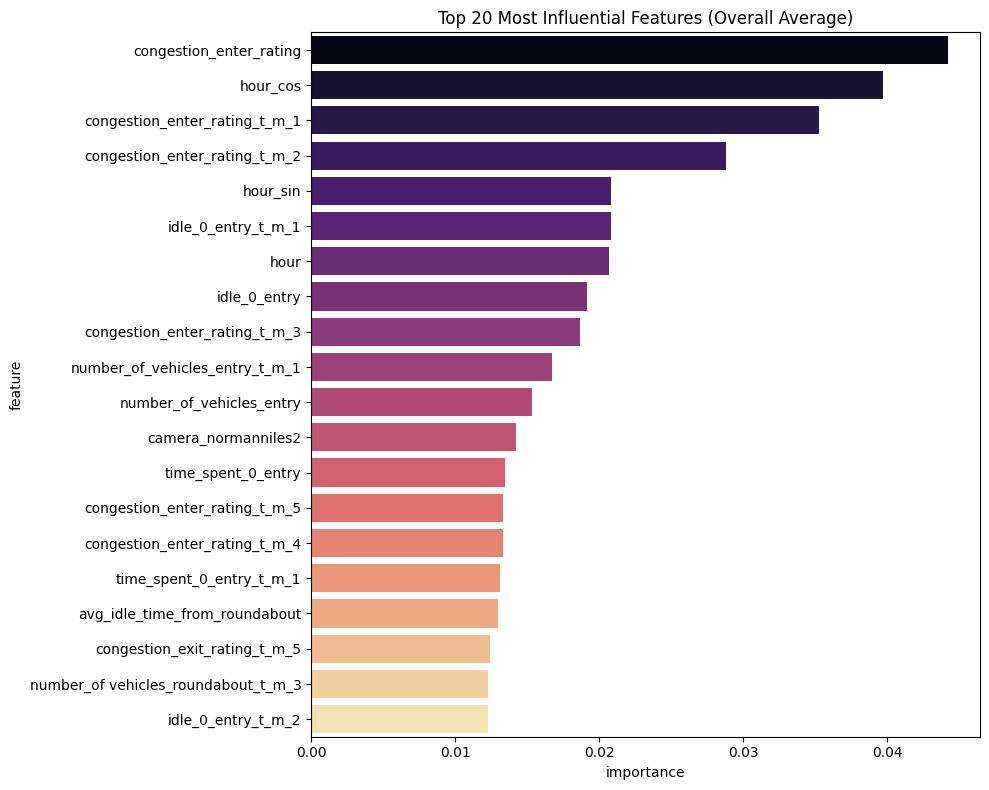

Training Complete. All models and analysis saved to folder: 'traffic_analysis_results_01'


In [ ]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, f1_score

# 1. Setup & Configuration
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
target_cols = y_enter.columns.tolist()

# Prepare directory for outputs
model_dir = 'traffic_analysis_results_01'
os.makedirs(model_dir, exist_ok=True)

# Data containers
fold_results = []
all_importances = []
weights = compute_sample_weight(class_weight='balanced', y=y_enter[target_cols[0]])

print(f"\n{'='*75}")
print(f"XGBoost Multi-Target Training: 10 Folds x 5 Time Steps (50 Models Total)")
print(f"Features: {X.shape[1]} | Samples: {X.shape[0]}")
print(f"{'='*75}\n")

# 2. Training Loop
fold_num = 0
for train_idx, val_idx in skf.split(X, y_enter[target_cols[0]]):
    fold_num += 1

    # Slice features and targets
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train_df, y_val_df = y_enter.iloc[train_idx], y_enter.iloc[val_idx]
    train_weights = weights[train_idx]

    all_target_preds = []

    # Create sub-directory for this specific fold
    fold_path = os.path.join(model_dir, f'fold_{fold_num}')
    os.makedirs(fold_path, exist_ok=True)

    for col in target_cols:
        # Initialize model for this specific minute
        model = XGBClassifier(
            n_estimators=2000,
            learning_rate=0.01,
            max_depth=3,
            early_stopping_rounds=50,
            objective='multi:softprob',
            eval_metric='mlogloss',
            random_state=42,
            tree_method='hist',
            subsample=0.8,
            colsample_bytree=0.8,
            max_delta_step=1
        )

        # Fit with Early Stopping and Weights
        model.fit(
            X_train, y_train_df[col],
            sample_weight=train_weights,
            eval_set=[(X_val, y_val_df[col])],
            verbose=False
        )

        # A. Capture Feature Importance for this specific target
        imp_df = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_,
            'target': col,
            'fold': fold_num
        })
        all_importances.append(imp_df)

        # B. Save the model
        model.save_model(os.path.join(fold_path, f'model_{col}.json'))

        # C. Predict for evaluation
        all_target_preds.append(model.predict(X_val))

    # 3. Fold Evaluation
    y_pred_final = np.column_stack(all_target_preds)

    # Flatten across all 5 minutes to get a total performance score
    y_val_flat = y_val_df.to_numpy().flatten()
    y_pred_flat = y_pred_final.flatten()

    fold_acc = accuracy_score(y_val_flat, y_pred_flat)
    fold_f1_macro = f1_score(y_val_flat, y_pred_flat, average="macro", zero_division=0)

    fold_results.append({
        "fold": fold_num,
        "accuracy": fold_acc,
        "f1_macro": fold_f1_macro
    })

    print(f"Fold {fold_num:02d}: Global Acc={fold_acc:.4f} | F1-Macro={fold_f1_macro:.4f}")

# --- 4. Post-Training Analysis ---

# Process Feature Importance
total_importance_df = pd.concat(all_importances)

# Calculate global importance (average across all folds and all time-steps)
global_importance = total_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False).reset_index()
global_importance.to_csv(os.path.join(model_dir, 'global_feature_importance.csv'), index=False)

# Calculate importance per target (t_1, t_2... etc)
target_importance = total_importance_df.groupby(['target', 'feature'])['importance'].mean().reset_index()
target_importance.to_csv(os.path.join(model_dir, 'importance_by_time_step.csv'), index=False)

# 5. Final Metrics and Metadata
fold_df = pd.DataFrame(fold_results)
fold_df.to_csv(os.path.join(model_dir, 'cv_metrics.csv'), index=False)

metadata = {
    'timestamp': datetime.now().isoformat(),
    'n_folds': n_splits,
    'mean_accuracy': float(fold_df['accuracy'].mean()),
    'std_accuracy': float(fold_df['accuracy'].std()),
    'mean_f1_macro': float(fold_df['f1_macro'].mean()),
    'top_5_features': global_importance['feature'].head(5).tolist(),
    'model_config': {
        'model_type': 'XGBoostClassifier',
        'n_estimators': 2000,
        'learning_rate': 0.01,
        'max_depth': 3,
        'early_stopping_rounds': 50,
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'random_state': 42,
        'tree_method': 'hist',
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'max_delta_step': 1
    },
}

with open(os.path.join(model_dir, 'summary_metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=4)

# 6. Final Report Visualization
print(f"\n{'-'*75}")
print(f"FINAL RESULTS")
print(f"Average Accuracy: {metadata['mean_accuracy']:.4f} (+/- {metadata['std_accuracy']:.4f})")
print(f"Average F1-Macro: {metadata['mean_f1_macro']:.4f}")
print(f"{'-'*75}\n")

# Visualize Top 20 Features
plt.figure(figsize=(10, 8))
sns.barplot(data=global_importance.head(20), x='importance', y='feature', palette='magma')
plt.title('Top 20 Most Influential Features (Overall Average)')
plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'top_features_plot.png'))
plt.show()

print(f"Training Complete. All models and analysis saved to folder: '{model_dir}'")

In [ ]:
!zip -r traffic_analysis_results_01.zip traffic_analysis_results_01

  adding: traffic_analysis_results_01/ (stored 0%)
  adding: traffic_analysis_results_01/fold_5/ (stored 0%)
  adding: traffic_analysis_results_01/fold_5/model_congestion_enter_rating_t_3.json (deflated 79%)
  adding: traffic_analysis_results_01/fold_5/model_congestion_enter_rating_t_5.json (deflated 79%)
  adding: traffic_analysis_results_01/fold_5/model_congestion_enter_rating_t_1.json (deflated 79%)
  adding: traffic_analysis_results_01/fold_5/model_congestion_enter_rating_t_2.json (deflated 79%)
  adding: traffic_analysis_results_01/fold_5/model_congestion_enter_rating_t_4.json (deflated 79%)
  adding: traffic_analysis_results_01/fold_4/ (stored 0%)
  adding: traffic_analysis_results_01/fold_4/model_congestion_enter_rating_t_3.json (deflated 79%)
  adding: traffic_analysis_results_01/fold_4/model_congestion_enter_rating_t_5.json (deflated 79%)
  adding: traffic_analysis_results_01/fold_4/model_congestion_enter_rating_t_1.json (deflated 79%)
  adding: traffic_analysis_results_01/fol

In [ ]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.multioutput import MultiOutputClassifier
# from xgboost import XGBClassifier
# from sklearn.utils.class_weight import compute_sample_weight
# import os
# import json

# n_splits = 10
# skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
# lst_accu_stratified = []

# weights = compute_sample_weight(
#     class_weight='balanced',
#     y=y_enter['congestion_enter_rating_t_1']
# )

# # base_classifier = XGBClassifier(
# #     n_estimators=100,
# #     early_stopping_rounds=500,
# #     learning_rate=0.05,
# #     max_depth=4,
# #     objective='multi:softprob',
# #     eval_metric='mlogloss',
# #     tree_method='hist',
# #     random_state=42
# # )

# # model = MultiOutputClassifier(base_classifier)

# fold_results = []
# feature_importance_list = []
# models_list = []

# print(f"\n{'='*70}")
# print(f"Training: XGBoostClassifier")
# print(f"Samples: {X.shape[0]}, Features: {X.shape[1]}, Classes: {len(np.unique(y_enter))}")
# print(f"{'='*70}\n")

# target_cols = y_enter.columns.tolist()

# fold_num = 0
# for train_idx, val_idx in skf.split(X, y_enter['congestion_enter_rating_t_1']):
#   fold_num += 1

#   X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#   y_train, y_val = y_enter.iloc[train_idx], y_enter.iloc[val_idx]
#   train_weights = weights[train_idx]

#   all_target_preds = []

#   for col in target_cols:
#     model = XGBClassifier(
#         n_estimators=1000,
#         learning_rate=0.05,
#         max_depth=4,
#         early_stopping_rounds=50,
#         objective='multi:softprob',
#         eval_metric='mlogloss',
#         random_state=42
#     )

#     # Fit model for this specific time step
#     model.fit(
#         X_train, y_train[col],
#         sample_weight=train_weights,
#         eval_set=[(X_val, y_val[col])], # Validating against the specific time step
#         verbose=False
#     )

#     y_pred_single_col = model.predict(X_val)
#     all_target_preds.append(y_pred_single_col)

#   y_pred_final = np.column_stack(all_target_preds)

#   y_val_flat = y_val.to_numpy().flatten()
#   y_pred_flat = y_pred_final.flatten()

#   fold_acc = accuracy_score(y_val_flat, y_pred_flat)
#   fold_f1_macro = f1_score(y_val_flat, y_pred_flat, average="macro", zero_division=0)

#   fold_results.append({
#       "fold": fold_num,
#       "accuracy": fold_acc,
#       "f1_macro": fold_f1_macro
#   })

#   feature_importance_list.append(model.feature_importances_)
#   models_list.append(model)

#   print(f"Fold {fold_num} : Accuracy={fold_acc:.4f}, F1-Macro={fold_f1_macro:.4f}")

# fold_df = pd.DataFrame(fold_results)

# print(f"\n{'-'*70}")
# print(f"Mean Accuracy: {fold_df['accuracy'].mean():.4f} (+/- {fold_df['accuracy'].std():.4f})")
# print(f"Mean F1-Macro: {fold_df['f1_macro'].mean():.4f} (+/- {fold_df['f1_macro'].std():.4f})")
# print(f"{'-'*70}\n")

# model_dir = 'models'
# os.makedirs(model_dir, exist_ok=True)

# for fold_idx, fold_model in enumerate(models_list, 1):
#   model_path = os.path.join(model_dir, f'model_fold_{fold_idx}.txt')
#   fold_model.save_model(model_path)
# results_path = os.path.join(model_dir, 'results.csv')
# fold_df.to_csv(results_path, index=False)

# metadata = {
#     'model_name': 'XGBoostClassifier',
#     'timestamp': datetime.now().isoformat(),
#     'n_folds': n_splits,
#     'mean_accuracy': float(fold_df['accuracy'].mean()),
#     'std_accuracy': float(fold_df['accuracy'].std()),
#     'mean_f1_macro': float(fold_df['f1_macro'].mean()),
#     'std_f1_macro': float(fold_df['f1_macro'].std()),
#     'feature_count': len(X.columns)
# }
# metadata_path = os.path.join(model_dir, 'metadata.json')
# with open(metadata_path, 'w') as f:
#   json.dump(metadata, f, indent=4)


Training: XGBoostClassifier
Samples: 1178, Features: 84, Classes: 4



XGBoostError: [17:30:03] /workspace/include/xgboost/objective.h:107: multioutput is not supported by the current objective function
Stack trace:
  [bt] (0) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x2be09c) [0x7da5aa8be09c]
  [bt] (1) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x6ef1d2) [0x7da5aacef1d2]
  [bt] (2) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(XGBoosterBoostedRounds+0x34) [0x7da5aa7c83d4]
  [bt] (3) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7da5f1c56e2e]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7da5f1c53493]
  [bt] (5) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x98c1) [0x7da5f2fd68c1]
  [bt] (6) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x8ffe) [0x7da5f2fd5ffe]
  [bt] (7) /usr/bin/python3(_PyObject_MakeTpCall+0x2fb) [0x53f5db]
  [bt] (8) /usr/bin/python3(_PyEval_EvalFrameDefault+0x701) [0x54a2e1]

